In [1]:
# Sean Dougherty
# 1/27/2023
# import librariws
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, LogLocator)
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import scipy.stats.distributions as dist
from time import sleep
from tqdm import tqdm
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
gamma = 1.4
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # 0.7 for omega
import pickle
from scipy.stats import distributions
from scipy.interpolate import interp1d
import scipy
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

SAVE_PATH = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/conv_prob/'

## Compute weighted AGN fraction and enhancement

In [7]:
# read in output frrom conv_agn_merger and combine field dfs
fields = ['GDS','EGS','COS','GDN','UDS','COSMOS']
ztype='p'
Mlo = 9.4
N_controls = 3
min_pp = 0.1
date='1.28' 
dfs = {}
cdfs = {}
Prp_dfs = {}

for field in tqdm(fields):
    # read in gtrue_pairs - the true pair df
    file = 'conv_output/PAIRS_Pp-'+str(min_pp)+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.parquet'
    dfs[field] = pd.read_parquet(SAVE_PATH+file)
    # read in Prp arrays
    with fits.open(SAVE_PATH+'Prp_output/Prp_Pp-'+str(min_pp)+'_M-'+str(Mlo)+'_ztype-'+ztype+'_'+field+'_'+date+'.fits') as data:
        Prp_dfs[field] = pd.DataFrame(data[0].data)
    # read in control_df - the control pair df
    cfile = 'control_output/APPLES_Pp-'+str(min_pp)+'_M-'+str(Mlo)+'_N-'+str(N_controls)+'_ztype-'+ztype+'_'+field+'_'+date+'.parquet'
    cdfs[field] = pd.read_parquet(SAVE_PATH+cfile)

# conbine all the field dataframes and arrays
print('concatinating P(rp) array... please wait.')
Prp_df = pd.concat(Prp_dfs).reset_index(drop=True)
Prp_arr = np.array(Prp_df)[:,2:]
print('Done. Thanks for waiting!')

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s]


concatinating P(rp) array... please wait.
Done. Thanks for waiting!


In [8]:
def make_bins_PDF(max_dist=100, n_bins=10):
    """
    Creates bins of projected separation and stores them in a dictionary.
    INPUTS
    : max_dist - int - maximum bin value
    : n_bins   - int - how may bins to divide up the range of 0-max_dist
    RETURNS
    : all_bins - dictionary - dictionary with string integer keys ('0'-str(n_bins)) and values of bin ranges as strings.
                              for example, {'0': '0.0-25.0'}
    """
    # create bin sizes
    all_bins = {}
    for bn in range(0, n_bins):
        # define limits for each bin
        all_bins[str(bn)] = str((max_dist/n_bins)*bn)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*bn)
    return all_bins

def weighted_quantile(values, quantiles, sample_weight=None):
    """
    Finds qunatiles in weighted data (i.e., z in galaxies weighted by P_pair)
    INPUTS
    : values        - np.array - data
    : quantiles     - np.array - percentiles between 0 and 1 that you want returned (i.e., [0.25, 0.5, 0.75])
    : sample_weight - np.array - data weights, is no weight are given then all weights = 1
    RETURNS
    : - np.array  - specified quantiles of weighted data, interpolated to get exact quantiles
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    # if no weights are given, just assume they all have equal weighting (i.e., =1)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'
    # always sort values
    sorter = np.argsort(values)
    values = values[sorter]
    sample_weight = sample_weight[sorter]
    # deternimed specified quantiles of the given weighted data
    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)
    # interpolate to match specified quantiles
    return np.interp(quantiles, weighted_quantiles, values)

def bootstrap(obs, weights, n_boots=250):
    """
    bootstrapping function for weighted AGN fractions
    INPUTS
    : obs     - np.array - count of AGN in each pair (0, 1, or 2)
    : weights - np.array - pair probabilities of corresponding galaxy pairs
    : n_boots - int - number of samples to draw in bootstrap
    RETURNS
    : - float - the standard error estimated from the variance of the weighted AGN fraction distribution created via bootstrap
    """
    # initialize empty arrays:
    boot_frac = np.zeros(n_boots)
    obs_idx = np.arange(0, len(weights), 1)
    for i in range(n_boots):
        # choose random pair indexes
        boot_d = np.random.choice(obs_idx, size=len(obs), replace=True)
        obs_it = obs[boot_d] # N_AGN for the chosen pairs
        weights_it = weights[boot_d] # weights for the chosen pairs
        # calculate the weighted AGN fraction from those pairs:
        boot_frac[i] = np.sum(obs_it * weights_it) / np.sum(weights_it)
    # finally, estimate the standard error from the variance
    return np.sqrt( np.sum( (boot_frac-np.mean(boot_frac))**2 ) / (n_boots-1) )

def bootstrap_obsc(obsc_obs, X_obs, weights, n_boots=250):
    """
    Bootrap function for specifically obscuration fraction
    INPUTS
    : obsc_obs  - np.array - count of obscured AGN in each pair (0, 1, or 2)
    : X_obs     - np.array - count of X-ray AGN in each pair (0, 1, or 2)
    : weights   - np.array - pair probabilities of corresponding galaxy pairs
    : n_boots   - int - number of samples to draw in bootstrap
    RETURNS
    : - float - the standard error estimated from the variance of the weighted AGN fraction distribution created via bootstrap
    """
    # initialize empty arrays:
    boot_frac = np.zeros(n_boots)
    obs_idx = np.arange(0, len(obsc_obs), 1)
    for i in range(n_boots):
        # choose random pair indexes
        boot_d = np.random.choice(obs_idx, size=len(X_obs), replace=True)
        obsc_it = obsc_obs[boot_d] # N_OBSC AGN for the chosen pairs
        Xray_it = X_obs[boot_d] # N_X-ray AGN for the chosen pairs
        weights_it = weights[boot_d] # weights for the chosen pairs
        # calculate the weighted AGN fraction from those pairs:
        boot_frac[i] = np.sum(obsc_it*weights_it) / np.sum(Xray_it*weights_it)
    # finally, estimate the standard error from the variance
    return np.sqrt( np.sum( (boot_frac-np.mean(boot_frac))**2 ) / (n_boots-1) )

def bin_analysis(bin_df, ibin_df, Prp_arr, low, high, prime_mass_lo, prime_z_lo, prime_z_hi, 
                   mr_lo, mr_hi, fields, AGN_type, p_lo=0, N_controls=3, plot_param=False, f_obsc=False):
    """
    Main function to determine AGN fractions, errors, and counts for certain bins and galaxy populations.
    INPUTS
    : bin_df        - pd.DataFrame - true pair df (rdf)
    : ibin_df       - pd.DataFrame - control pair df (cdf)
    : Prp_arr       - 2D np.array  - True pair projected separation probability distributions. Each row gives the IDs of the pair
                                     followed by P(rp) from 0 to 200 kpc (in steps of 0.1 kpc)
    : low           - int - min proj sep of current bin
    : high          - int - max proj sep of current bin
    : prime_mass_lo - float - min log(stellar mass) of the more massive galaxy in a pair. 
                              Major complete sample > 10 and minor complete > 10.4 log(M*/Mo)
    : prime_z_lo    - float - min redshift (of the more massive, 'prime', galaxy in a pair)
    : prime_z_hi    - float - max redshift (of the more massive, 'prime', galaxy in a pair)
    : mr_lo         - float - min mass ratio. Masses or on log scale, so major pairs have mr_lo = log(1) and mr_hi = log(4/1)
                              and minor pairs have mr_lo = log(4/1) and mr_hi = log(10/1)
    : mr_hi         - float - max mass ratio
    : fields        - np.array of strings - fields included in these calculations
    : AGN_type      - string - in preparing for the anlaysis, we have created different AGN flags in the true and control dfs.
                               Choose one of: 'lowLX'   - log(LX) = 42-43.2 erg s^-1
                                              'midLX'   - log(LX) = 43.2-43.7
                                              'hiLX'    - log(LX) > 43.7 
                                              'allLX'   - log(LX) > 42 
                                              'IRallLX' - Donley IR AGN but log(LX) !> 42
                                              'IR'      - Donley IR AGN
    : p_lo          - float - minimum pair probability to consider a true pair, default = 0 (i.e., considers all)
    : N_controls    - int - number of control pairs selected for each true pair, defined when loading in data
    : plot_param    - boolean - if True, code plots, for z, log(mass), environmental density, and log(P(z) width):
                                (1) normalized weighted histograms and
                                (2) a Q-Q plot, with the median and upper/lower 68% confidence intervals plotted as red crosses
    : f_obsc        - boolean - if True, code returns obs, PP, iobs, and iPP (see below), which are needed for obscuration fraction
    RETURNS
    : high_p  - int - the count of all true pairs of pair probability greater than 1%
    : sum_p   - float - sum of the pair probabilities of all true pairs
    : count   - float - sum of all AGN (weighted by cooresponding paur probabilities) in all true pairs
    : frac    - float - weighted AGN fraction for true pairs
    : se      - float - standard error (via bootstrap) of the true pair weighted AGN fraction
    : ihigh_p - int - the count of all control pairs of pair probability greater than 1%
    : isum_p  - float - sum of the pair probabilities of all control pairs
    : icount  - float - sum of all AGN (weighted by cooresponding paur probabilities) in all control pairs
    : ifrac   - float - weighted AGN fraction for control pairs
    : ise     - float - standard error (via bootstrap) of the control pair weighted AGN fraction
    : obs     - array - count of AGN in each true pair (0, 1, or 2)
    : PP      - array - pair probabilities of true pairs
    : iobs    - array - count of AGN in each control pair (0, 1, or 2)
    : iPP     - array - pair probabilities of control pairs
    """
    # define rp grid
    rp = np.linspace(0, 200, num=2001)
    # select the desired subsample from the true pair df
    df = bin_df.loc[ (bin_df['prime_M'] > prime_mass_lo) & (bin_df['pair_prob'] > p_lo) & 
                              (bin_df['prime_z'] > prime_z_lo) & (bin_df['prime_z'] < prime_z_hi) &
                              (bin_df['mass_ratio'] >= mr_lo) & (bin_df['mass_ratio'] < mr_hi) &
                             (bin_df['field'].isin(fields) == True) ]
    # select the corresponding P(rp)'s for the chosen galaxy pairs above
    Prp = Prp_arr[df.index]
    # calculate P_rp (proj sep probability) based on the current bin edges (low and high)
    Pr = np.trapz(Prp[:, np.where((rp > low) & (rp <= high))], x=rp[np.where((rp > low) & (rp <= high))])
    # calculate P_pair = P_dV * P_rp (see paper)
    PP = np.array(df['pair_prob']) * Pr[:,0]
    # pure AGN counts (N_AGN, aka observations)
    obs = np.array(df[AGN_type])
    # sum of N_AGN weighted by pair probability (P_pair)
    count =  np.sum(PP * obs)
    # how many true pairs have P_pair > 0.01
    high_p = len(obs[np.where(PP > 0.01)])
    # sum of all pair probabilities
    sum_p = np.sum(PP)
    # normalized weights
    PPn = PP / np.sum(PP)
    # calculate weighted AGN fraction
    frac = np.sum(obs * PPn)
    # obtain the standard error via a bootstrap
    se = bootstrap(obs, PP)
        
    # the same values caluclated for the control galaxy pairs ('i' indicated 'isolated')
    # use the pair_ID column in the control df to get all the corresponding control galaxies for the selected true pairs
    idf = ibin_df.loc[ (ibin_df['pair_ID'].isin(df['pair_ID']) == True) ]
    iPP = np.array(idf['Cp'])*np.repeat(Pr[:,0], N_controls)
    iobs = np.array(idf[AGN_type])
    icount = np.sum(iPP * iobs)
    ihigh_p = len(iobs[np.where(iPP > 0.01)])
    isum_p = np.sum(iPP)
    iPPn = iPP / np.sum(iPP)
    ifrac = np.sum(iobs * iPPn)  
    ise = bootstrap(iobs, iPP)
        
    # add proj sep probability (P_rp in paper; 'Pr' below) and pair probability (P_pair; 'Final_P') to dfs
    df['Pr'] = Pr
    df['Final_P'] = PP
    idf['Pr'] = np.repeat(Pr[:,0], N_controls)
    idf['Final_P'] = iPP
        
    # option to return specific parameter plot for a bin with displayed weighted quantiles
    if plot_param != False:
        params = ['z', 'M', 'env', 'PDFsig']
        iparams = ['z', 'MASS', 'ENV', 'SIG']
        # get quantile data for Q-Q plot
        quants = np.arange(0.01, 0.99, 0.01).round(2)
        p_w = np.concatenate( (df['Final_P'], df['Final_P']) )
        i_w = np.concatenate( (idf['Final_P'], idf['Final_P']) )
        fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(26,12))
        for i, (plot_par, iplot_par) in enumerate(zip(params, iparams)):
            pz = np.concatenate( (df['prime_'+plot_par], df['partner_'+plot_par]) )
            iz = np.concatenate( (idf[iplot_par+'1'], idf[iplot_par+'2']) )
            # find good bins to use for distributions
            if plot_par == 'PDFsig':
                # need to use logscale for P(z) width as the vast majority of them are on the scale of 0.1
                bins = np.logspace(-2.1,1,30)
                # make axes look nicer
                ax[0,i].set_xscale('log')
                ax[0,i].set_yscale('log')
                ax[1,i].set_xscale('log')
                ax[1,i].set_yscale('log')
                ax[0,i].xaxis.set_major_locator(LogLocator(base=10))
                ax[0,i].xaxis.set_minor_locator(LogLocator(base=10,subs=np.arange(0.1,1,0.1)))
                ax[0,i].yaxis.set_major_locator(LogLocator(base=10))
                ax[0,i].yaxis.set_minor_locator(LogLocator(base=10,subs=np.arange(0.1,1,0.1)))
                ax[0,i].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
                ax[0,i].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
                ax[1,i].xaxis.set_major_locator(LogLocator(base=10))
                ax[1,i].xaxis.set_minor_locator(LogLocator(base=10,subs=np.arange(0.1,1,0.1)))
                ax[1,i].yaxis.set_major_locator(LogLocator(base=10))
                ax[1,i].yaxis.set_minor_locator(LogLocator(base=10,subs=np.arange(0.1,1,0.1)))
                ax[1,i].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
                ax[1,i].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
            else:
                mins = np.min(pz)
                maxs = np.max(iz)
                bins = np.linspace(mins - 0.1*mins, maxs + 0.1*maxs, 40)
                ax[0,i].set_xlim(mins, maxs)
                ax[1,i].set_xlim(mins, maxs)
                ax[1,i].set_ylim(mins, maxs)
                ax[0,i].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
                ax[0,i].xaxis.set_minor_locator(AutoMinorLocator())
                ax[0,i].yaxis.set_minor_locator(AutoMinorLocator())
                ax[0,i].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
                ax[1,i].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
                ax[1,i].xaxis.set_minor_locator(AutoMinorLocator())
                ax[1,i].yaxis.set_minor_locator(AutoMinorLocator())
                ax[1,i].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
            # plot weighted distributions
            ax[0,i].hist(pz, bins=bins, weights=p_w, histtype='step', density=True, color='blue')
            ax[0,i].hist(iz, bins=bins, weights=i_w, histtype='step', density=True, color='red', linestyle='--')
            ax[0,i].set_xlabel(plot_par, fontsize=20)
            ax[0,0].set_ylabel('Density', fontsize=20)
            # construct q-q plpt
            p_wpercs = weighted_quantile(pz, quants, sample_weight=p_w)
            i_wpercs = weighted_quantile(iz, quants, sample_weight=i_w)
            ax[1,i].plot([0,100], [0,100], color='black', zorder=1)
            # highlight some key percentiles median and upper/lower 68% confidence intervals:
            ax[1,i].scatter(p_wpercs[np.where(quants==0.5)], i_wpercs[np.where(quants==0.5)], 
                            s=200, color='red', marker='+', zorder=3)
            ax[1,i].scatter(p_wpercs[np.where(quants==0.84)], i_wpercs[np.where(quants==0.84)], 
                            s=200, color='red', marker='+', zorder=3)
            ax[1,i].scatter(p_wpercs[np.where(quants==0.16)], i_wpercs[np.where(quants==0.16)], 
                            s=200, color='red', marker='+', zorder=3)
            ax[1,i].scatter(p_wpercs, i_wpercs, facecolor='none', edgecolor='black', zorder=2)
            ax[1,0].text(0.7, 2.5, 'Q-Q Plot', fontsize=25)
            ax[1,i].set_xlabel('True pairs', fontsize=20)
            ax[1,0].set_ylabel('Control pairs', fontsize=20)
        plt.show()
    
    # return extra data if subsample (allLX and IRallLX) needed in later obscuration fraction calculation
    if f_obsc == False:
        return high_p, sum_p, count, frac, se, ihigh_p, isum_p, icount, ifrac, ise
    else:
        return high_p, sum_p, count, frac, se, ihigh_p, isum_p, icount, ifrac, ise, obs, PP, iobs, iPP


In [9]:
#############################################
### %%% PREPARE DATA FOR BIN ANALYSIS %%% ###
#############################################
max_dist=100
n_bins=4
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)
# extract bin location info for plotting later
kpc_meds = np.array([ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ])
kpc_centers = np.array([((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)])
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])
# define mass limits for major and minor mergers
maj_mr = np.log10(4)
min_mr = 1
bottom = 0
rp = np.linspace(0, 200, num=2001) # rp grid
# define LX and redshift subsample boundaries
lowLX = 42
midLX = 43.2
hiLX = 43.7
z_bottom = 0.5
z_mid1 = 1
z_mid2 = 2
z_top = 3

# combine the dataframes
rdf = pd.concat(dfs).reset_index(drop=True) # true pair df
cdf = pd.concat(cdfs).reset_index(drop=True) # control pair df

# if pp, ps, and ss have different variances, then we need to know which pairs fall into each catagory:
# designate ptypes (pair types - phot-phot, spec-phot, spec-spec; all zpecs have P(z) width = 0.01)
rdf['ptype'] = ['pp']*len(rdf)
cdf['ptype'] = ['pp']*len(cdf)
if ztype != 'p':
    rdf.loc[ (rdf['prime_zt'] == 's') & (rdf['partner_zt'] == 's'), 'ptype' ] = 'ss'
    rdf.loc[ ((rdf['prime_zt'] == 's') & (rdf['partner_zt'] == 'p')) | ((rdf['prime_zt'] == 'p') & (rdf['partner_zt'] == 's')), 'ptype' ] = 'ps'
    cdf.loc[ (cdf['SIG1'] == 0.01) & (cdf['SIG2'] == 0.01), 'ptype' ] = 'ss'
    cdf.loc[ ((cdf['SIG1'] == 0.01) & (cdf['SIG2'] != 0.01)) | ((cdf['SIG1'] != 0.01) & (cdf['SIG2'] == 0.01)), 'ptype' ] = 'ps'

# keep control df in-line with true pair df cuts using pair ID strings
rdf['pair_ID'] = rdf['field'] +'_'+ (rdf['prime_ID'].astype(int)).astype(str) +'+'+ (rdf['partner_ID'].astype(int)).astype(str)
cdf['pair_ID'] = cdf['field'] +'_'+ (cdf['P_ID1'].astype(int)).astype(str) +'+'+ (cdf['P_ID2'].astype(int)).astype(str)
cdf['apple_ID'] = cdf['field'] +'_'+ (cdf['ID1'].astype(int)).astype(str) +'+'+ (cdf['ID2'].astype(int)).astype(str)

# fix negaive LX values to 1 to avoid log10 divide by zero warning:
rdf.loc[rdf['prime_LX'] <= 0, 'prime_LX'] = 1
rdf.loc[rdf['partner_LX'] <= 0, 'partner_LX'] = 1
cdf.loc[cdf['LX1'] <= 0, 'LX1'] = 1
cdf.loc[cdf['LX2'] <= 0, 'LX2'] = 1

# flag AGN in individual galaxies then count them in pairs
rdf['lowX_1'] = [0]*len(rdf) # low LX AGN
rdf['lowX_2'] = [0]*len(rdf)
rdf['midX_1'] = [0]*len(rdf) # mid LX AGN
rdf['midX_2'] = [0]*len(rdf)
rdf['hiX_1'] = [0]*len(rdf) # high LX AGN
rdf['hiX_2'] = [0]*len(rdf)
rdf['X_1'] = [0]*len(rdf) # all LX AGN
rdf['IRX_1'] = [0]*len(rdf) # IR-only AGN (obscured)
rdf['X_2'] = [0]*len(rdf)
rdf['IRX_2'] = [0]*len(rdf)
rdf['IR_1'] = [0]*len(rdf) # IR AGN
rdf['IR_2'] = [0]*len(rdf)
rdf.loc[ (np.log10(rdf['prime_LX']) > lowLX) & (np.log10(rdf['prime_LX']) < midLX), 'lowX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > lowLX) & (np.log10(rdf['partner_LX']) < midLX), 'lowX_2' ] = 1
rdf['lowLX'] = rdf['lowX_1'] + rdf['lowX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > midLX) & (np.log10(rdf['prime_LX']) < hiLX), 'midX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > midLX) & (np.log10(rdf['partner_LX']) < hiLX), 'midX_2' ] = 1
rdf['midLX'] = rdf['midX_1'] + rdf['midX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > hiLX), 'hiX_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > hiLX), 'hiX_2' ] = 1
rdf['hiLX'] = rdf['hiX_1'] + rdf['hiX_2']
rdf.loc[ (np.log10(rdf['prime_LX']) > lowLX), 'X_1' ] = 1
rdf.loc[ (np.log10(rdf['partner_LX']) > lowLX), 'X_2' ] = 1
rdf['allLX'] = rdf['X_1'] + rdf['X_2']
rdf.loc[ (rdf['prime_IR_AGN_DON'] == 1), 'IR_1' ] = 1
rdf.loc[ (rdf['partner_IR_AGN_DON'] == 1), 'IR_2' ] = 1
rdf['IR'] = rdf['IR_1'] + rdf['IR_2']
rdf.loc[ (rdf['IR_1'] == 1) & (rdf['X_1'] != 1), 'IRX_1' ] = 1
rdf.loc[ (rdf['IR_2'] == 1) & (rdf['X_2'] != 1), 'IRX_2' ] = 1
rdf['IRallLX'] = rdf['IRX_1'] + rdf['IRX_2']

cdf['lowX_1'] = [0]*len(cdf)
cdf['lowX_2'] = [0]*len(cdf)
cdf['midX_1'] = [0]*len(cdf)
cdf['midX_2'] = [0]*len(cdf)
cdf['hiX_1'] = [0]*len(cdf)
cdf['hiX_2'] = [0]*len(cdf)
cdf['X_1'] = [0]*len(cdf)
cdf['IRX_1'] = [0]*len(cdf)
cdf['X_2'] = [0]*len(cdf)
cdf['IRX_2'] = [0]*len(cdf)
cdf['IR_1'] = [0]*len(cdf)
cdf['IR_2'] = [0]*len(cdf)
cdf.loc[ (np.log10(cdf['LX1']) > lowLX) & (np.log10(cdf['LX1']) < midLX), 'lowX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > lowLX) & (np.log10(cdf['LX2']) < midLX), 'lowX_2' ] = 1
cdf['lowLX'] = cdf['lowX_1'] + cdf['lowX_2']
cdf.loc[ (np.log10(cdf['LX1']) > midLX) & (np.log10(cdf['LX1']) < hiLX), 'midX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > midLX) & (np.log10(cdf['LX2']) < hiLX), 'midX_2' ] = 1
cdf['midLX'] = cdf['midX_1'] + cdf['midX_2']
cdf.loc[ (np.log10(cdf['LX1']) > hiLX), 'hiX_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > hiLX), 'hiX_2' ] = 1
cdf['hiLX'] = cdf['hiX_1'] + cdf['hiX_2']
cdf.loc[ (np.log10(cdf['LX1']) > lowLX), 'X_1' ] = 1
cdf.loc[ (np.log10(cdf['LX2']) > lowLX), 'X_2' ] = 1
cdf['allLX'] = cdf['X_1'] + cdf['X_2']
cdf.loc[ (cdf['IR_AGN_DON1'] == 1), 'IR_1' ] = 1
cdf.loc[ (cdf['IR_AGN_DON2'] == 1), 'IR_2' ] = 1
cdf['IR'] = cdf['IR_1'] + cdf['IR_2']
cdf.loc[ (cdf['IR_1'] == 1) & (cdf['X_1'] != 1), 'IRX_1' ] = 1
cdf.loc[ (cdf['IR_2'] == 1) & (cdf['X_2'] != 1), 'IRX_2' ] = 1
cdf['IRallLX'] =  cdf['IRX_1'] + cdf['IRX_2']

# create dictionaries to put bin results in
major, minor, major_minor = {},{},{}
### major: M1:M4 < 4:1, log(M1)>10
### minor: 4:1 < M1:M4 < 10:1, log(M1)>10.4
### major_minor: M1:M4 < 10:1, log(M1)>10.4
data = ['NhiP', 'sumP','count','frac','se'] # output statistics:
### NhiP: count of pair with pair probability > 0.01
### sumP: sum of all pair probabilities, i.e. weighted pair count
### count: sum of weighted AGN
### frac: weighted AGN fraction
### se: standard error (via bootstrap)
# Make some keys:
AGN_type = ['lowLX','midLX','hiLX','allLX','IR', 'ilowLX','imidLX','ihiLX','iallLX','iIR', 'IRallLX', 'iIRallLX']
for AGN in AGN_type:
    for dat in data:
        major[AGN+'_'+dat] = {}
        minor[AGN+'_'+dat] = {}
        major_minor[AGN+'_'+dat] = {}
# Make keys for the LX and z samples
major_z = {}
AGN_type_z = ['midLX_zlo', 'midLX_zmid', 'hiLX_zlo', 'hiLX_zmid', 'hiLX_zhi', 'allLX_zlo', 'allLX_zmid', 'allLX_zhi',
             'imidLX_zlo', 'imidLX_zmid', 'ihiLX_zlo', 'ihiLX_zmid', 'ihiLX_zhi', 'iallLX_zlo', 'iallLX_zmid', 'iallLX_zhi']
for AGN in AGN_type_z:
    for dat in data:
        major_z[AGN+'_'+dat] = {}
# Make a dictionary to store values needed for determining the obscuration fraction
obsc_dict = {}
entries = ['IRallLX_obs', 'IRallLX_PP', 'allLX_obs', 'allLX_PP', 'iIRallLX_obs', 'iIRallLX_PP', 'iallLX_obs', 'iallLX_PP']
for ent in entries:
    obsc_dict[ent] = {}

# collect distribution of entire data
pz = np.concatenate( (rdf['prime_z'], rdf['partner_z']) )
pmass = np.concatenate( (rdf['prime_M'], rdf['partner_M']) )
psig = np.concatenate( (rdf['prime_PDFsig'], rdf['partner_PDFsig']) )
penv = np.concatenate( (rdf['prime_env'], rdf['partner_env']) )
iz = np.concatenate( (cdf['z1'], cdf['z2']) )
imass = np.concatenate( (cdf['MASS1'], cdf['MASS2']) )
isig = np.concatenate( (cdf['SIG1'], cdf['SIG2']) )
ienv = np.concatenate( (cdf['ENV1'], cdf['ENV2']) )

In [10]:
####################################
### %%% PERFORM BIN ANALYSIS %%% ###
####################################
# loop through all the bins:
for i, rnge in tqdm(enumerate(bins)):
    print('Analyzing data in bin {}...'.format(bins[rnge]))
    # get bin ranges from bins dictionary entries
    info = bins[rnge].split('-')
    low = float(info[0])
    high = float(info[1])
    # define the pair and control dfs to new bin dfs
    bin_df = rdf
    ibin_df = cdf.loc[ (cdf['pair_ID'].isin(bin_df['pair_ID']) == True) ]

    # begin the closest bin at 5 kpc to avoid source confusion issues
    if i == 0:
        low = 5    

    ######################
    ### %%% MAJOR %%% ####
    ######################
    # run bin_analysis with dfs, bin edges, sample selection, etc., as inputs (see function cell earlier for details) 
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, 0.5, 2,
                          0, np.log10(4), ['GDS','GDN'], 'lowLX')
    # place results in the appropriate dictionary locations:
    major['lowLX_NhiP'][bins[rnge]] = results[0]
    major['lowLX_sumP'][bins[rnge]] = results[1]
    major['lowLX_count'][bins[rnge]] = results[2]
    major['lowLX_frac'][bins[rnge]] = results[3]
    major['lowLX_se'][bins[rnge]] = results[4]
    major['ilowLX_NhiP'][bins[rnge]] = results[5]
    major['ilowLX_sumP'][bins[rnge]] = results[6]
    major['ilowLX_count'][bins[rnge]] = results[7]
    major['ilowLX_frac'][bins[rnge]] = results[8]
    major['ilowLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, 0.5, 2,
                          0, np.log10(4), fields, 'midLX')
    major['midLX_NhiP'][bins[rnge]] = results[0]
    major['midLX_sumP'][bins[rnge]] = results[1]
    major['midLX_count'][bins[rnge]] = results[2]
    major['midLX_frac'][bins[rnge]] = results[3]
    major['midLX_se'][bins[rnge]] = results[4]
    major['imidLX_NhiP'][bins[rnge]] = results[5]
    major['imidLX_sumP'][bins[rnge]] = results[6]
    major['imidLX_count'][bins[rnge]] = results[7]
    major['imidLX_frac'][bins[rnge]] = results[8]
    major['imidLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'hiLX')
    major['hiLX_NhiP'][bins[rnge]] = results[0]
    major['hiLX_sumP'][bins[rnge]] = results[1]
    major['hiLX_count'][bins[rnge]] = results[2]
    major['hiLX_frac'][bins[rnge]] = results[3]
    major['hiLX_se'][bins[rnge]] = results[4]
    major['ihiLX_NhiP'][bins[rnge]] = results[5]
    major['ihiLX_sumP'][bins[rnge]] = results[6]
    major['ihiLX_count'][bins[rnge]] = results[7]
    major['ihiLX_frac'][bins[rnge]] = results[8]
    major['ihiLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'allLX', f_obsc=True) # NOTE: needed for obscured fraction calc below
    major['allLX_NhiP'][bins[rnge]] = results[0]
    major['allLX_sumP'][bins[rnge]] = results[1]
    major['allLX_count'][bins[rnge]] = results[2]
    major['allLX_frac'][bins[rnge]] = results[3]
    major['allLX_se'][bins[rnge]] = results[4]
    major['iallLX_NhiP'][bins[rnge]] = results[5]
    major['iallLX_sumP'][bins[rnge]] = results[6]
    major['iallLX_count'][bins[rnge]] = results[7]
    major['iallLX_frac'][bins[rnge]] = results[8]
    major['iallLX_se'][bins[rnge]] = results[9]
    obsc_dict['allLX_obs'][bins[rnge]] = results[10]
    obsc_dict['allLX_PP'][bins[rnge]] = results[11]
    obsc_dict['iallLX_obs'][bins[rnge]] = results[12]
    obsc_dict['iallLX_PP'][bins[rnge]] = results[13]

    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'IRallLX', f_obsc=True) # NOTE: needed for obscured fraction calc below
    major['IRallLX_NhiP'][bins[rnge]] = results[0]
    major['IRallLX_sumP'][bins[rnge]] = results[1]
    major['IRallLX_count'][bins[rnge]] = results[2]
    major['IRallLX_frac'][bins[rnge]] = results[3]
    major['IRallLX_se'][bins[rnge]] = results[4]
    major['iIRallLX_NhiP'][bins[rnge]] = results[5]
    major['iIRallLX_sumP'][bins[rnge]] = results[6]
    major['iIRallLX_count'][bins[rnge]] = results[7]
    major['iIRallLX_frac'][bins[rnge]] = results[8]
    major['iIRallLX_se'][bins[rnge]] = results[9]
    obsc_dict['IRallLX_obs'][bins[rnge]] = results[10]
    obsc_dict['IRallLX_PP'][bins[rnge]] = results[11]
    obsc_dict['iIRallLX_obs'][bins[rnge]] = results[12]
    obsc_dict['iIRallLX_PP'][bins[rnge]] = results[13]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'IR')
    major['IR_NhiP'][bins[rnge]] = results[0]
    major['IR_sumP'][bins[rnge]] = results[1]
    major['IR_count'][bins[rnge]] = results[2]
    major['IR_frac'][bins[rnge]] = results[3]
    major['IR_se'][bins[rnge]] = results[4]
    major['iIR_NhiP'][bins[rnge]] = results[5]
    major['iIR_sumP'][bins[rnge]] = results[6]
    major['iIR_count'][bins[rnge]] = results[7]
    major['iIR_frac'][bins[rnge]] = results[8]
    major['iIR_se'][bins[rnge]] = results[9]
    
    
    ######################
    ### %%% MINOR %%% ####
    #####################
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 2,
                          np.log10(4), np.log10(10), ['GDS','GDN'], 'lowLX')
    minor['lowLX_NhiP'][bins[rnge]] = results[0]
    minor['lowLX_sumP'][bins[rnge]] = results[1]
    minor['lowLX_count'][bins[rnge]] = results[2]
    minor['lowLX_frac'][bins[rnge]] = results[3]
    minor['lowLX_se'][bins[rnge]] = results[4]
    minor['ilowLX_NhiP'][bins[rnge]] = results[5]
    minor['ilowLX_sumP'][bins[rnge]] = results[6]
    minor['ilowLX_count'][bins[rnge]] = results[7]
    minor['ilowLX_frac'][bins[rnge]] = results[8]
    minor['ilowLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 2,
                          np.log10(4), np.log10(10), fields, 'midLX')
    minor['midLX_NhiP'][bins[rnge]] = results[0]
    minor['midLX_sumP'][bins[rnge]] = results[1]
    minor['midLX_count'][bins[rnge]] = results[2]
    minor['midLX_frac'][bins[rnge]] = results[3]
    minor['midLX_se'][bins[rnge]] = results[4]
    minor['imidLX_NhiP'][bins[rnge]] = results[5]
    minor['imidLX_sumP'][bins[rnge]] = results[6]
    minor['imidLX_count'][bins[rnge]] = results[7]
    minor['imidLX_frac'][bins[rnge]] = results[8]
    minor['imidLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 3,
                          np.log10(4), np.log10(10), fields, 'hiLX')
    minor['hiLX_NhiP'][bins[rnge]] = results[0]
    minor['hiLX_sumP'][bins[rnge]] = results[1]
    minor['hiLX_count'][bins[rnge]] = results[2]
    minor['hiLX_frac'][bins[rnge]] = results[3]
    minor['hiLX_se'][bins[rnge]] = results[4]
    minor['ihiLX_NhiP'][bins[rnge]] = results[5]
    minor['ihiLX_sumP'][bins[rnge]] = results[6]
    minor['ihiLX_count'][bins[rnge]] = results[7]
    minor['ihiLX_frac'][bins[rnge]] = results[8]
    minor['ihiLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 3,
                          np.log10(4), np.log10(10), fields, 'allLX')
    minor['allLX_NhiP'][bins[rnge]] = results[0]
    minor['allLX_sumP'][bins[rnge]] = results[1]
    minor['allLX_count'][bins[rnge]] = results[2]
    minor['allLX_frac'][bins[rnge]] = results[3]
    minor['allLX_se'][bins[rnge]] = results[4]
    minor['iallLX_NhiP'][bins[rnge]] = results[5]
    minor['iallLX_sumP'][bins[rnge]] = results[6]
    minor['iallLX_count'][bins[rnge]] = results[7]
    minor['iallLX_frac'][bins[rnge]] = results[8]
    minor['iallLX_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 3,
                          np.log10(4), np.log10(10), fields, 'IRallLX')
    minor['IRallLX_NhiP'][bins[rnge]] = results[0]
    minor['IRallLX_sumP'][bins[rnge]] = results[1]
    minor['IRallLX_count'][bins[rnge]] = results[2]
    minor['IRallLX_frac'][bins[rnge]] = results[3]
    minor['IRallLX_se'][bins[rnge]] = results[4]
    minor['iIRallLX_NhiP'][bins[rnge]] = results[5]
    minor['iIRallLX_sumP'][bins[rnge]] = results[6]
    minor['iIRallLX_count'][bins[rnge]] = results[7]
    minor['iIRallLX_frac'][bins[rnge]] = results[8]
    minor['iIRallLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 3,
                          np.log10(4), np.log10(10), fields, 'IR')
    minor['IR_NhiP'][bins[rnge]] = results[0]
    minor['IR_sumP'][bins[rnge]] = results[1]
    minor['IR_count'][bins[rnge]] = results[2]
    minor['IR_frac'][bins[rnge]] = results[3]
    minor['IR_se'][bins[rnge]] = results[4]
    minor['iIR_NhiP'][bins[rnge]] = results[5]
    minor['iIR_sumP'][bins[rnge]] = results[6]
    minor['iIR_count'][bins[rnge]] = results[7]
    minor['iIR_frac'][bins[rnge]] = results[8]
    minor['iIR_se'][bins[rnge]] = results[9]
    
    
    ############################
    ### %%% MAJOR MINOR %%% ####
    ############################
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 2,
                          0, np.log10(10), ['GDS','GDN'], 'lowLX')
    major_minor['lowLX_NhiP'][bins[rnge]] = results[0]
    major_minor['lowLX_sumP'][bins[rnge]] = results[1]
    major_minor['lowLX_count'][bins[rnge]] = results[2]
    major_minor['lowLX_frac'][bins[rnge]] = results[3]
    major_minor['lowLX_se'][bins[rnge]] = results[4]
    major_minor['ilowLX_NhiP'][bins[rnge]] = results[5]
    major_minor['ilowLX_sumP'][bins[rnge]] = results[6]
    major_minor['ilowLX_count'][bins[rnge]] = results[7]
    major_minor['ilowLX_frac'][bins[rnge]] = results[8]
    major_minor['ilowLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 2,
                          0, np.log10(10), fields, 'midLX')
    major_minor['midLX_NhiP'][bins[rnge]] = results[0]
    major_minor['midLX_sumP'][bins[rnge]] = results[1]
    major_minor['midLX_count'][bins[rnge]] = results[2]
    major_minor['midLX_frac'][bins[rnge]] = results[3]
    major_minor['midLX_se'][bins[rnge]] = results[4]
    major_minor['imidLX_NhiP'][bins[rnge]] = results[5]
    major_minor['imidLX_sumP'][bins[rnge]] = results[6]
    major_minor['imidLX_count'][bins[rnge]] = results[7]
    major_minor['imidLX_frac'][bins[rnge]] = results[8]
    major_minor['imidLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 3,
                          0, np.log10(10), fields, 'hiLX')
    major_minor['hiLX_NhiP'][bins[rnge]] = results[0]
    major_minor['hiLX_sumP'][bins[rnge]] = results[1]
    major_minor['hiLX_count'][bins[rnge]] = results[2]
    major_minor['hiLX_frac'][bins[rnge]] = results[3]
    major_minor['hiLX_se'][bins[rnge]] = results[4]
    major_minor['ihiLX_NhiP'][bins[rnge]] = results[5]
    major_minor['ihiLX_sumP'][bins[rnge]] = results[6]
    major_minor['ihiLX_count'][bins[rnge]] = results[7]
    major_minor['ihiLX_frac'][bins[rnge]] = results[8]
    major_minor['ihiLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 3,
                          0, np.log10(10), fields, 'allLX')
    major_minor['allLX_NhiP'][bins[rnge]] = results[0]
    major_minor['allLX_sumP'][bins[rnge]] = results[1]
    major_minor['allLX_count'][bins[rnge]] = results[2]
    major_minor['allLX_frac'][bins[rnge]] = results[3]
    major_minor['allLX_se'][bins[rnge]] = results[4]
    major_minor['iallLX_NhiP'][bins[rnge]] = results[5]
    major_minor['iallLX_sumP'][bins[rnge]] = results[6]
    major_minor['iallLX_count'][bins[rnge]] = results[7]
    major_minor['iallLX_frac'][bins[rnge]] = results[8]
    major_minor['iallLX_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 3,
                          0, np.log10(10), fields, 'IRallLX')
    major_minor['IRallLX_NhiP'][bins[rnge]] = results[0]
    major_minor['IRallLX_sumP'][bins[rnge]] = results[1]
    major_minor['IRallLX_count'][bins[rnge]] = results[2]
    major_minor['IRallLX_frac'][bins[rnge]] = results[3]
    major_minor['IRallLX_se'][bins[rnge]] = results[4]
    major_minor['iIRallLX_NhiP'][bins[rnge]] = results[5]
    major_minor['iIRallLX_sumP'][bins[rnge]] = results[6]
    major_minor['iIRallLX_count'][bins[rnge]] = results[7]
    major_minor['iIRallLX_frac'][bins[rnge]] = results[8]
    major_minor['iIRallLX_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10.4, 0.5, 3,
                          0, np.log10(10), fields, 'IR')
    major_minor['IR_NhiP'][bins[rnge]] = results[0]
    major_minor['IR_sumP'][bins[rnge]] = results[1]
    major_minor['IR_count'][bins[rnge]] = results[2]
    major_minor['IR_frac'][bins[rnge]] = results[3]
    major_minor['IR_se'][bins[rnge]] = results[4]
    major_minor['iIR_NhiP'][bins[rnge]] = results[5]
    major_minor['iIR_sumP'][bins[rnge]] = results[6]
    major_minor['iIR_count'][bins[rnge]] = results[7]
    major_minor['iIR_frac'][bins[rnge]] = results[8]
    major_minor['iIR_se'][bins[rnge]] = results[9]
    
    
    ##############################
    ### %%% LX AND Z CUTS %%% ####
    ##############################
    # # get the redshift cuts in LX - only for major mergers
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, z_bottom, z_mid1,
                          0, np.log10(4), fields, 'midLX')
    major_z['midLX_zlo_NhiP'][bins[rnge]] = results[0]
    major_z['midLX_zlo_sumP'][bins[rnge]] = results[1]
    major_z['midLX_zlo_count'][bins[rnge]] = results[2]
    major_z['midLX_zlo_frac'][bins[rnge]] = results[3]
    major_z['midLX_zlo_se'][bins[rnge]] = results[4]
    major_z['imidLX_zlo_NhiP'][bins[rnge]] = results[5]
    major_z['imidLX_zlo_sumP'][bins[rnge]] = results[6]
    major_z['imidLX_zlo_count'][bins[rnge]] = results[7]
    major_z['imidLX_zlo_frac'][bins[rnge]] = results[8]
    major_z['imidLX_zlo_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, z_bottom, z_mid1,
                          0, np.log10(4), fields, 'hiLX')
    major_z['hiLX_zlo_NhiP'][bins[rnge]] = results[0]
    major_z['hiLX_zlo_sumP'][bins[rnge]] = results[1]
    major_z['hiLX_zlo_count'][bins[rnge]] = results[2]
    major_z['hiLX_zlo_frac'][bins[rnge]] = results[3]
    major_z['hiLX_zlo_se'][bins[rnge]] = results[4]
    major_z['ihiLX_zlo_NhiP'][bins[rnge]] = results[5]
    major_z['ihiLX_zlo_sumP'][bins[rnge]] = results[6]
    major_z['ihiLX_zlo_count'][bins[rnge]] = results[7]
    major_z['ihiLX_zlo_frac'][bins[rnge]] = results[8]
    major_z['ihiLX_zlo_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, z_bottom, z_mid1,
                          0, np.log10(4), fields, 'allLX')
    major_z['allLX_zlo_NhiP'][bins[rnge]] = results[0]
    major_z['allLX_zlo_sumP'][bins[rnge]] = results[1]
    major_z['allLX_zlo_count'][bins[rnge]] = results[2]
    major_z['allLX_zlo_frac'][bins[rnge]] = results[3]
    major_z['allLX_zlo_se'][bins[rnge]] = results[4]
    major_z['iallLX_zlo_NhiP'][bins[rnge]] = results[5]
    major_z['iallLX_zlo_sumP'][bins[rnge]] = results[6]
    major_z['iallLX_zlo_count'][bins[rnge]] = results[7]
    major_z['iallLX_zlo_frac'][bins[rnge]] = results[8]
    major_z['iallLX_zlo_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, z_mid1, z_mid2,
                          0, np.log10(4), fields, 'midLX')
    major_z['midLX_zmid_NhiP'][bins[rnge]] = results[0]
    major_z['midLX_zmid_sumP'][bins[rnge]] = results[1]
    major_z['midLX_zmid_count'][bins[rnge]] = results[2]
    major_z['midLX_zmid_frac'][bins[rnge]] = results[3]
    major_z['midLX_zmid_se'][bins[rnge]] = results[4]
    major_z['imidLX_zmid_NhiP'][bins[rnge]] = results[5]
    major_z['imidLX_zmid_sumP'][bins[rnge]] = results[6]
    major_z['imidLX_zmid_count'][bins[rnge]] = results[7]
    major_z['imidLX_zmid_frac'][bins[rnge]] = results[8]
    major_z['imidLX_zmid_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, z_mid1, z_mid2,
                          0, np.log10(4), fields, 'hiLX')
    major_z['hiLX_zmid_NhiP'][bins[rnge]] = results[0]
    major_z['hiLX_zmid_sumP'][bins[rnge]] = results[1]
    major_z['hiLX_zmid_count'][bins[rnge]] = results[2]
    major_z['hiLX_zmid_frac'][bins[rnge]] = results[3]
    major_z['hiLX_zmid_se'][bins[rnge]] = results[4]
    major_z['ihiLX_zmid_NhiP'][bins[rnge]] = results[5]
    major_z['ihiLX_zmid_sumP'][bins[rnge]] = results[6]
    major_z['ihiLX_zmid_count'][bins[rnge]] = results[7]
    major_z['ihiLX_zmid_frac'][bins[rnge]] = results[8]
    major_z['ihiLX_zmid_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, z_mid1, z_mid2,
                          0, np.log10(4), fields, 'allLX')
    major_z['allLX_zmid_NhiP'][bins[rnge]] = results[0]
    major_z['allLX_zmid_sumP'][bins[rnge]] = results[1]
    major_z['allLX_zmid_count'][bins[rnge]] = results[2]
    major_z['allLX_zmid_frac'][bins[rnge]] = results[3]
    major_z['allLX_zmid_se'][bins[rnge]] = results[4]
    major_z['iallLX_zmid_NhiP'][bins[rnge]] = results[5]
    major_z['iallLX_zmid_sumP'][bins[rnge]] = results[6]
    major_z['iallLX_zmid_count'][bins[rnge]] = results[7]
    major_z['iallLX_zmid_frac'][bins[rnge]] = results[8]
    major_z['iallLX_zmid_se'][bins[rnge]] = results[9]
    
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, z_mid2, z_top,
                          0, np.log10(4), fields, 'hiLX')
    major_z['hiLX_zhi_NhiP'][bins[rnge]] = results[0]
    major_z['hiLX_zhi_sumP'][bins[rnge]] = results[1]
    major_z['hiLX_zhi_count'][bins[rnge]] = results[2]
    major_z['hiLX_zhi_frac'][bins[rnge]] = results[3]
    major_z['hiLX_zhi_se'][bins[rnge]] = results[4]
    major_z['ihiLX_zhi_NhiP'][bins[rnge]] = results[5]
    major_z['ihiLX_zhi_sumP'][bins[rnge]] = results[6]
    major_z['ihiLX_zhi_count'][bins[rnge]] = results[7]
    major_z['ihiLX_zhi_frac'][bins[rnge]] = results[8]
    major_z['ihiLX_zhi_se'][bins[rnge]] = results[9]
    results = bin_analysis(bin_df, ibin_df, Prp_arr, low, high, 10, z_mid2, z_top,
                          0, np.log10(4), fields, 'allLX')
    major_z['allLX_zhi_NhiP'][bins[rnge]] = results[0]
    major_z['allLX_zhi_sumP'][bins[rnge]] = results[1]
    major_z['allLX_zhi_count'][bins[rnge]] = results[2]
    major_z['allLX_zhi_frac'][bins[rnge]] = results[3]
    major_z['allLX_zhi_se'][bins[rnge]] = results[4]
    major_z['iallLX_zhi_NhiP'][bins[rnge]] = results[5]
    major_z['iallLX_zhi_sumP'][bins[rnge]] = results[6]
    major_z['iallLX_zhi_count'][bins[rnge]] = results[7]
    major_z['iallLX_zhi_frac'][bins[rnge]] = results[8]
    major_z['iallLX_zhi_se'][bins[rnge]] = results[9]
    
    
print('Done!')


0it [00:00, ?it/s]

Analyzing data in bin 0.0-25.0...


1it [01:12, 72.15s/it]

Analyzing data in bin 25.0-50.0...


2it [02:20, 69.71s/it]

Analyzing data in bin 50.0-75.0...


3it [03:28, 68.95s/it]

Analyzing data in bin 75.0-100.0...


4it [04:37, 69.25s/it]

Done!


In [11]:
# copy the dicts into new z_type specific dictionaries and save
# run again for different z_type mode to save both versions
if ztype == 'ps':
    ps_major = major.copy()
    ps_minor = minor.copy()
    ps_major_minor = major_minor.copy()
    ps_major_z = major_z.copy()
    ps_obsc_dict = obsc_dict.copy()
    # I should save these to not reshuffle the bootstrap...
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_major.pkl', 'wb') as f:
        pickle.dump(ps_major, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_minor.pkl', 'wb') as f:
        pickle.dump(ps_minor, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_major_z.pkl', 'wb') as f:
        pickle.dump(ps_major_z, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_obsc_dict.pkl', 'wb') as f:
        pickle.dump(ps_obsc_dict, f)
else:
    p_major = major.copy()
    p_minor = minor.copy()
    p_major_minor = major_minor.copy()
    p_major_z = major_z.copy()
    p_obsc_dict = obsc_dict.copy()
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_major.pkl', 'wb') as f:
        pickle.dump(p_major, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_minor.pkl', 'wb') as f:
        pickle.dump(p_minor, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_major_z.pkl', 'wb') as f:
        pickle.dump(p_major_z, f)
    with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_obsc_dict.pkl', 'wb') as f:
        pickle.dump(p_obsc_dict, f)
    

In [12]:
# if you exited jupyter, load back the previous results back in here
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_major.pkl', 'rb') as f:
    ps_major = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_minor.pkl', 'rb') as f:
    ps_minor = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_major_z.pkl', 'rb') as f:
    ps_major_z = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/ps_obsc_dict.pkl', 'rb') as f:
    ps_obsc_dict = pickle.load(f)

# and for the p runs
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_major.pkl', 'rb') as f:
    p_major = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_minor.pkl', 'rb') as f:
    p_minor = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_major_z.pkl', 'rb') as f:
    p_major_z = pickle.load(f)
with open('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/p_obsc_dict.pkl', 'rb') as f:
    p_obsc_dict = pickle.load(f)

# recreate bins:
max_dist=100
n_bins=4
bins = make_bins_PDF(max_dist=max_dist, n_bins=n_bins)
kpc_meds = np.array([ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ])
kpc_centers = np.array([((kpc_meds[i] + kpc_meds[i+1])/2) for i in range(0, len(kpc_meds)-1)])
# define violin plot width
vwidth = float((bins['0'].split('-'))[1]) - float((bins['0'].split('-'))[0])

In [13]:
# create DataFrames to make into tables for paper:
# this isn't set to the ps or p mode, just what was most recently run
cols = [bins[i] for i in bins.keys()]
#############################
### %%% All X-ray AGN %%% ###
#############################
hiP_count = pd.DataFrame([major['allLX_NhiP']])
sumP = pd.DataFrame([major['allLX_sumP']])
P_XAGN = pd.DataFrame([major['allLX_count']])
XAGN_frac = pd.DataFrame([major['allLX_frac']])
XAGN_se = pd.DataFrame([major['allLX_se']])
ihiP_count = pd.DataFrame([major['iallLX_NhiP']])
isumP = pd.DataFrame([major['iallLX_sumP']])
iP_XAGN = pd.DataFrame([major['iallLX_count']])
iXAGN_frac = pd.DataFrame([major['iallLX_frac']])
iXAGN_se = pd.DataFrame([major['iallLX_se']])
# get AGN enhancement information
XAGN_fr = XAGN_frac.to_numpy()[0]
XAGN_e = XAGN_se.to_numpy()[0]
iXAGN_fr = iXAGN_frac.to_numpy()[0]
iXAGN_e = iXAGN_se.to_numpy()[0]
XAGN_enh = XAGN_fr / iXAGN_fr
XAGN_enh_se = XAGN_enh * np.sqrt( (XAGN_e/XAGN_fr)**2 + (iXAGN_e/iXAGN_fr)**2 )
# tabulate date:
### TP: true pair
### CP: control pair
### ... SE: standard error
XAGN_e = pd.DataFrame([XAGN_e], columns=cols)
iXAGN_e = pd.DataFrame([iXAGN_e], columns=cols)
XAGN_enh = pd.DataFrame([XAGN_enh], columns=cols)
XAGN_enh_se = pd.DataFrame([XAGN_enh_se], columns=cols)
# create tables:
X_df = pd.concat([hiP_count, sumP, P_XAGN, XAGN_frac, XAGN_e,
                 ihiP_count, isumP, iP_XAGN, iXAGN_frac, iXAGN_e, 
                  XAGN_enh, XAGN_enh_se], ignore_index = True, axis=0)
X_df = X_df.rename(index={0:'TP N(high prob)', 1:'TP Sum(weighted pairs)', 2:'TP Sum(weighted AGN)', 
                          3:'TP weighted AGN fraction', 4:'TP weighted AGN fraction SE',
                         5:'CP N(high prob)', 6:'CP Sum(weighted pairs)', 7:'CP Sum(weighted AGN)', 
                          8:'CP weighted AGN fraction', 9:'CP weighted AGN fraction SE',
                         10: 'AGN enhancement', 11:'AGN enhancement SE'})

#############################
### %%% All IR AGN %%% ######
#############################
P_IRAGN = pd.DataFrame([major['IR_count']])
IRAGN_frac = pd.DataFrame([major['IR_frac']])
IRAGN_se = pd.DataFrame([major['IR_se']])
iP_IRAGN = pd.DataFrame([major['iIR_count']])
iIRAGN_frac = pd.DataFrame([major['iIR_frac']])
iIRAGN_se = pd.DataFrame([major['iIR_se']])
# get enhancement information
IRAGN_fr = IRAGN_frac.to_numpy()[0]
IRAGN_e = IRAGN_se.to_numpy()[0]
iIRAGN_fr = iIRAGN_frac.to_numpy()[0]
iIRAGN_e = iIRAGN_se.to_numpy()[0]
IRAGN_enh = IRAGN_fr / iIRAGN_fr
IRAGN_enh_se = IRAGN_enh * np.sqrt( (IRAGN_e/IRAGN_fr)**2 + (iIRAGN_e/iIRAGN_fr)**2 )
IRAGN_e = pd.DataFrame([IRAGN_e], columns=cols)
iIRAGN_e = pd.DataFrame([iIRAGN_e], columns=cols)
IRAGN_enh = pd.DataFrame([IRAGN_enh], columns=cols)
IRAGN_enh_se = pd.DataFrame([IRAGN_enh_se], columns=cols)
# create tables
IR_df = pd.concat([hiP_count, sumP, P_IRAGN, IRAGN_frac, IRAGN_e,
                 ihiP_count, isumP, iP_IRAGN, iIRAGN_frac, iIRAGN_e,
                  IRAGN_enh,IRAGN_enh_se ], ignore_index = True, axis=0)
IR_df = IR_df.rename(index={0:'TP N(high prob)', 1:'TP Sum(weighted pairs)', 2:'TP Sum(weighted AGN)', 
                          3:'TP weighted AGN fraction', 4:'TP weighted AGN fraction SE',
                         5:'CP N(high prob)', 6:'CP Sum(weighted pairs)', 7:'CP Sum(weighted AGN)', 
                          8:'CP weighted AGN fraction', 9:'CP weighted AGN fraction SE',
                         10: 'AGN enhancement', 11:'AGN enhancement SE'})

##########################
### %%% Mid LX AGN %%% ###
##########################
midLX_hiP_count = pd.DataFrame([major['midLX_NhiP']])
midLX_sumP = pd.DataFrame([major['midLX_sumP']])
midLX_XAGN = pd.DataFrame([major['midLX_count']])
midLX_XAGN_frac = pd.DataFrame([major['midLX_frac']])
midLX_XAGN_se = pd.DataFrame([major['midLX_se']])
imidLX_hiP_count = pd.DataFrame([major['imidLX_NhiP']])
imidLX_sumP = pd.DataFrame([major['imidLX_sumP']])
imidLX_XAGN = pd.DataFrame([major['imidLX_count']])
imidLX_XAGN_frac = pd.DataFrame([major['imidLX_frac']])
imidLX_XAGN_se = pd.DataFrame([major['imidLX_se']])
# get enhancement information
midLX_XAGN_fr = midLX_XAGN_frac.to_numpy()[0]
midLX_XAGN_e = midLX_XAGN_se.to_numpy()[0]
imidLX_XAGN_fr = imidLX_XAGN_frac.to_numpy()[0]
imidLX_XAGN_e = imidLX_XAGN_se.to_numpy()[0]
midLX_XAGN_enh = midLX_XAGN_fr / imidLX_XAGN_fr
midLX_XAGN_enh_se = midLX_XAGN_enh * np.sqrt( (midLX_XAGN_e/midLX_XAGN_fr)**2 + (imidLX_XAGN_e/imidLX_XAGN_fr)**2 )
midLX_XAGN_e = pd.DataFrame([midLX_XAGN_e], columns=cols)
imidLX_XAGN_e = pd.DataFrame([imidLX_XAGN_e], columns=cols)
midLX_XAGN_enh = pd.DataFrame([midLX_XAGN_enh], columns=cols)
midLX_XAGN_enh_se = pd.DataFrame([midLX_XAGN_enh_se], columns=cols)
# tabulate tables:
midLX_df = pd.concat([midLX_hiP_count, midLX_sumP, midLX_XAGN, midLX_XAGN_frac, midLX_XAGN_e,
                 imidLX_hiP_count, imidLX_sumP, imidLX_XAGN, imidLX_XAGN_frac, imidLX_XAGN_e,
                    midLX_XAGN_enh, midLX_XAGN_enh_se], ignore_index = True, axis=0)
midLX_df = midLX_df.rename(index={0:'TP N(high prob)', 1:'TP Sum(weighted pairs)', 2:'TP Sum(weighted AGN)', 
                          3:'TP weighted AGN fraction', 4:'TP weighted AGN fraction SE',
                         5:'CP N(high prob)', 6:'CP Sum(weighted pairs)', 7:'CP Sum(weighted AGN)', 
                          8:'CP weighted AGN fraction', 9:'CP weighted AGN fraction SE',
                         10: 'AGN enhancement', 11:'AGN enhancement SE'})

###########################
### %%% High LX AGN %%% ###
###########################
hiLX_hiP_count = pd.DataFrame([major['hiLX_NhiP']])
hiLX_sumP = pd.DataFrame([major['hiLX_sumP']])
hiLX_XAGN = pd.DataFrame([major['hiLX_count']])
hiLX_XAGN_frac = pd.DataFrame([major['hiLX_frac']])
hiLX_XAGN_se = pd.DataFrame([major['hiLX_se']])
ihiLX_hiP_count = pd.DataFrame([major['ihiLX_NhiP']])
ihiLX_sumP = pd.DataFrame([major['ihiLX_sumP']])
ihiLX_XAGN = pd.DataFrame([major['ihiLX_count']])
ihiLX_XAGN_frac = pd.DataFrame([major['ihiLX_frac']])
ihiLX_XAGN_se = pd.DataFrame([major['ihiLX_se']])
# get enhancement information
hiLX_XAGN_fr = hiLX_XAGN_frac.to_numpy()[0]
hiLX_XAGN_e = hiLX_XAGN_se.to_numpy()[0]
ihiLX_XAGN_fr = ihiLX_XAGN_frac.to_numpy()[0]
ihiLX_XAGN_e = ihiLX_XAGN_se.to_numpy()[0]
hiLX_XAGN_enh = hiLX_XAGN_fr / ihiLX_XAGN_fr
hiLX_XAGN_enh_se = hiLX_XAGN_enh * np.sqrt( (hiLX_XAGN_e/hiLX_XAGN_fr)**2 + (ihiLX_XAGN_e/ihiLX_XAGN_fr)**2 )
hiLX_XAGN_e = pd.DataFrame([hiLX_XAGN_e], columns=cols)
ihiLX_XAGN_e = pd.DataFrame([ihiLX_XAGN_e], columns=cols)
hiLX_XAGN_enh = pd.DataFrame([hiLX_XAGN_enh], columns=cols)
hiLX_XAGN_enh_se = pd.DataFrame([hiLX_XAGN_enh_se], columns=cols)
# tabulate data
hiLX_df = pd.concat([hiLX_hiP_count, hiLX_sumP, hiLX_XAGN, hiLX_XAGN_frac, hiLX_XAGN_e,
                 ihiLX_hiP_count, ihiLX_sumP, ihiLX_XAGN, ihiLX_XAGN_frac, ihiLX_XAGN_e,
                   hiLX_XAGN_enh, hiLX_XAGN_enh_se], ignore_index = True, axis=0)
hiLX_df = hiLX_df.rename(index={0:'TP N(high prob)', 1:'TP Sum(weighted pairs)', 2:'TP Sum(weighted AGN)', 
                          3:'TP weighted AGN fraction', 4:'TP weighted AGN fraction SE',
                         5:'CP N(high prob)', 6:'CP Sum(weighted pairs)', 7:'CP Sum(weighted AGN)', 
                          8:'CP weighted AGN fraction', 9:'CP weighted AGN fraction SE',
                         10: 'AGN enhancement', 11:'AGN enhancement SE'})

######################################
### %%% IR only (obscured) AGN %%% ###
######################################
IRallLX_hiP_count = pd.DataFrame([major['IRallLX_NhiP']])
IRallLX_sumP = pd.DataFrame([major['IRallLX_sumP']])
IRallLX_IRAGN = pd.DataFrame([major['IRallLX_count']])
IRallLX_IRAGN_frac = pd.DataFrame([major['IRallLX_frac']])
IRallLX_IRAGN_se = pd.DataFrame([major['IRallLX_se']])
iIRallLX_hiP_count = pd.DataFrame([major['iIRallLX_NhiP']])
iIRallLX_sumP = pd.DataFrame([major['iIRallLX_sumP']])
iIRallLX_IRAGN = pd.DataFrame([major['iIRallLX_count']])
iIRallLX_IRAGN_frac = pd.DataFrame([major['iIRallLX_frac']])
iIRallLX_IRAGN_se = pd.DataFrame([major['iIRallLX_se']])
# get enhancement information
IRallLX_IRAGN_fr = IRallLX_IRAGN_frac.to_numpy()[0]
IRallLX_IRAGN_e = IRallLX_IRAGN_se.to_numpy()[0]
iIRallLX_IRAGN_fr = iIRallLX_IRAGN_frac.to_numpy()[0]
iIRallLX_IRAGN_e = iIRallLX_IRAGN_se.to_numpy()[0]
IRallLX_IRAGN_enh = IRallLX_IRAGN_fr / iIRallLX_IRAGN_fr
IRallLX_IRAGN_enh_se = IRallLX_IRAGN_enh * np.sqrt( (IRallLX_IRAGN_e/IRallLX_IRAGN_fr)**2 + (iIRallLX_IRAGN_e/iIRallLX_IRAGN_fr)**2 )
IRallLX_IRAGN_e = pd.DataFrame([IRallLX_IRAGN_e], columns=cols)
iIRallLX_IRAGN_e = pd.DataFrame([iIRallLX_IRAGN_e], columns=cols)
IRallLX_IRAGN_enh = pd.DataFrame([IRallLX_IRAGN_enh], columns=cols)
IRallLX_IRAGN_enh_se = pd.DataFrame([IRallLX_IRAGN_enh_se], columns=cols)
# tabulate data
IRallLX_df = pd.concat([IRallLX_hiP_count, IRallLX_sumP, IRallLX_IRAGN, IRallLX_IRAGN_frac, IRallLX_IRAGN_e,
                 iIRallLX_hiP_count, iIRallLX_sumP, iIRallLX_IRAGN, iIRallLX_IRAGN_frac, iIRallLX_IRAGN_e,
                      IRallLX_IRAGN_enh, IRallLX_IRAGN_enh_se], ignore_index = True, axis=0)
IRallLX_df = IRallLX_df.rename(index={0:'TP N(high prob)', 1:'TP Sum(weighted pairs)', 2:'TP Sum(weighted AGN)', 
                          3:'TP weighted AGN fraction', 4:'TP weighted AGN fraction SE',
                         5:'CP N(high prob)', 6:'CP Sum(weighted pairs)', 7:'CP Sum(weighted AGN)', 
                          8:'CP weighted AGN fraction', 9:'CP weighted AGN fraction SE',
                         10: 'AGN enhancement', 11:'AGN enhancement SE'})

################################
### %%% Mid LX AGN mid-z %%% ###
################################
midLX_zmid_hiP_count = pd.DataFrame([ps_major_z['midLX_zmid_NhiP']])
midLX_zmid_sumP = pd.DataFrame([ps_major_z['midLX_zmid_sumP']])
midLX_zmid_XAGN = pd.DataFrame([ps_major_z['midLX_zmid_count']])
midLX_zmid_XAGN_frac = pd.DataFrame([ps_major_z['midLX_zmid_frac']])
midLX_zmid_XAGN_se = pd.DataFrame([ps_major_z['midLX_zmid_se']])
imidLX_zmid_hiP_count = pd.DataFrame([ps_major_z['imidLX_zmid_NhiP']])
imidLX_zmid_sumP = pd.DataFrame([ps_major_z['imidLX_zmid_sumP']])
imidLX_zmid_XAGN = pd.DataFrame([ps_major_z['imidLX_zmid_count']])
imidLX_zmid_XAGN_frac = pd.DataFrame([ps_major_z['imidLX_zmid_frac']])
imidLX_zmid_XAGN_se = pd.DataFrame([ps_major_z['imidLX_zmid_se']])
# get enhancement information
midLX_zmid_XAGN_fr = midLX_zmid_XAGN_frac.to_numpy()[0]
midLX_zmid_XAGN_e = midLX_zmid_XAGN_se.to_numpy()[0]
imidLX_zmid_XAGN_fr = imidLX_zmid_XAGN_frac.to_numpy()[0]
imidLX_zmid_XAGN_e = imidLX_zmid_XAGN_se.to_numpy()[0]
midLX_zmid_XAGN_enh = midLX_zmid_XAGN_fr / imidLX_zmid_XAGN_fr
midLX_zmid_XAGN_enh_se = midLX_zmid_XAGN_enh * np.sqrt( (midLX_zmid_XAGN_e/midLX_zmid_XAGN_fr)**2 + (imidLX_zmid_XAGN_e/imidLX_zmid_XAGN_fr)**2 )
# make a separate errors table and just combine in post:
midLX_zmid_XAGN_e = pd.DataFrame([midLX_zmid_XAGN_e], columns=cols)
imidLX_zmid_XAGN_e = pd.DataFrame([imidLX_zmid_XAGN_e], columns=cols)
midLX_zmid_XAGN_enh = pd.DataFrame([midLX_zmid_XAGN_enh], columns=cols)
midLX_zmid_XAGN_enh_se = pd.DataFrame([midLX_zmid_XAGN_enh_se], columns=cols)
# tabulate data
midLX_zmid_df = pd.concat([midLX_zmid_hiP_count, midLX_zmid_sumP, midLX_zmid_XAGN, midLX_zmid_XAGN_frac, midLX_zmid_XAGN_e,
                 imidLX_zmid_hiP_count, imidLX_zmid_sumP, imidLX_zmid_XAGN, imidLX_zmid_XAGN_frac, imidLX_zmid_XAGN_e,
                  midLX_zmid_XAGN_enh, midLX_zmid_XAGN_enh_se], ignore_index = True, axis=0)
midLX_zmid_df = midLX_zmid_df.rename(index={0:'TP N(high prob)', 1:'TP Sum(weighted pairs)', 2:'TP Sum(weighted AGN)', 
                          3:'TP weighted AGN fraction', 4:'TP weighted AGN fraction SE',
                         5:'CP N(high prob)', 6:'CP Sum(weighted pairs)', 7:'CP Sum(weighted AGN)', 
                          8:'CP weighted AGN fraction', 9:'CP weighted AGN fraction SE',
                         10: 'AGN enhancement', 11:'AGN enhancement SE'})

#################################
### %%% High LX AGN mid-z %%% ###
#################################
hiLX_zmid_hiP_count = pd.DataFrame([ps_major_z['hiLX_zmid_NhiP']])
hiLX_zmid_sumP = pd.DataFrame([ps_major_z['hiLX_zmid_sumP']])
hiLX_zmid_XAGN = pd.DataFrame([ps_major_z['hiLX_zmid_count']])
hiLX_zmid_XAGN_frac = pd.DataFrame([ps_major_z['hiLX_zmid_frac']])
hiLX_zmid_XAGN_se = pd.DataFrame([ps_major_z['hiLX_zmid_se']])
ihiLX_zmid_hiP_count = pd.DataFrame([ps_major_z['ihiLX_zmid_NhiP']])
ihiLX_zmid_sumP = pd.DataFrame([ps_major_z['ihiLX_zmid_sumP']])
ihiLX_zmid_XAGN = pd.DataFrame([ps_major_z['ihiLX_zmid_count']])
ihiLX_zmid_XAGN_frac = pd.DataFrame([ps_major_z['ihiLX_zmid_frac']])
ihiLX_zmid_XAGN_se = pd.DataFrame([ps_major_z['ihiLX_zmid_se']])
# get enhancement information
hiLX_zmid_XAGN_fr = hiLX_zmid_XAGN_frac.to_numpy()[0]
hiLX_zmid_XAGN_e = hiLX_zmid_XAGN_se.to_numpy()[0]
ihiLX_zmid_XAGN_fr = ihiLX_zmid_XAGN_frac.to_numpy()[0]
ihiLX_zmid_XAGN_e = ihiLX_zmid_XAGN_se.to_numpy()[0]
hiLX_zmid_XAGN_enh = hiLX_zmid_XAGN_fr / ihiLX_zmid_XAGN_fr
hiLX_zmid_XAGN_enh_se = hiLX_zmid_XAGN_enh * np.sqrt( (hiLX_zmid_XAGN_e/hiLX_zmid_XAGN_fr)**2 + (ihiLX_zmid_XAGN_e/ihiLX_zmid_XAGN_fr)**2 )
# make a separate errors table and just combine in post:
hiLX_zmid_XAGN_e = pd.DataFrame([hiLX_zmid_XAGN_e], columns=cols)
ihiLX_zmid_XAGN_e = pd.DataFrame([ihiLX_zmid_XAGN_e], columns=cols)
hiLX_zmid_XAGN_enh = pd.DataFrame([hiLX_zmid_XAGN_enh], columns=cols)
hiLX_zmid_XAGN_enh_se = pd.DataFrame([hiLX_zmid_XAGN_enh_se], columns=cols)
# tabulate data
hiLX_zmid_df = pd.concat([hiLX_zmid_hiP_count, hiLX_zmid_sumP, hiLX_zmid_XAGN, hiLX_zmid_XAGN_frac, hiLX_zmid_XAGN_e,
                 ihiLX_zmid_hiP_count, ihiLX_zmid_sumP, ihiLX_zmid_XAGN, ihiLX_zmid_XAGN_frac, ihiLX_zmid_XAGN_e,
                 hiLX_zmid_XAGN_enh, hiLX_zmid_XAGN_enh_se], ignore_index = True, axis=0)
hiLX_zmid_df = hiLX_zmid_df.rename(index={0:'TP N(high prob)', 1:'TP Sum(weighted pairs)', 2:'TP Sum(weighted AGN)', 
                          3:'TP weighted AGN fraction', 4:'TP weighted AGN fraction SE',
                         5:'CP N(high prob)', 6:'CP Sum(weighted pairs)', 7:'CP Sum(weighted AGN)', 
                          8:'CP weighted AGN fraction', 9:'CP weighted AGN fraction SE',
                         10: 'AGN enhancement', 11:'AGN enhancement SE'})

##################################
### %%% High LX AGN high-z %%% ###
##################################
hiLX_zhi_hiP_count = pd.DataFrame([ps_major_z['hiLX_zhi_NhiP']])
hiLX_zhi_sumP = pd.DataFrame([ps_major_z['hiLX_zhi_sumP']])
hiLX_zhi_XAGN = pd.DataFrame([ps_major_z['hiLX_zhi_count']])
hiLX_zhi_XAGN_frac = pd.DataFrame([ps_major_z['hiLX_zhi_frac']])
hiLX_zhi_XAGN_se = pd.DataFrame([ps_major_z['hiLX_zhi_se']])
ihiLX_zhi_hiP_count = pd.DataFrame([ps_major_z['ihiLX_zhi_NhiP']])
ihiLX_zhi_sumP = pd.DataFrame([ps_major_z['ihiLX_zhi_sumP']])
ihiLX_zhi_XAGN = pd.DataFrame([ps_major_z['ihiLX_zhi_count']])
ihiLX_zhi_XAGN_frac = pd.DataFrame([ps_major_z['ihiLX_zhi_frac']])
ihiLX_zhi_XAGN_se = pd.DataFrame([ps_major_z['ihiLX_zhi_se']])
# get enhancement information
hiLX_zhi_XAGN_fr = hiLX_zhi_XAGN_frac.to_numpy()[0]
hiLX_zhi_XAGN_e = hiLX_zhi_XAGN_se.to_numpy()[0]
ihiLX_zhi_XAGN_fr = ihiLX_zhi_XAGN_frac.to_numpy()[0]
ihiLX_zhi_XAGN_e = ihiLX_zhi_XAGN_se.to_numpy()[0]
hiLX_zhi_XAGN_enh = hiLX_zhi_XAGN_fr / ihiLX_zhi_XAGN_fr
hiLX_zhi_XAGN_enh_se = hiLX_zhi_XAGN_enh * np.sqrt( (hiLX_zhi_XAGN_e/hiLX_zhi_XAGN_fr)**2 + (ihiLX_zhi_XAGN_e/ihiLX_zhi_XAGN_fr)**2 )
# make a separate errors table and just combine in post:
hiLX_zhi_XAGN_e = pd.DataFrame([hiLX_zhi_XAGN_e], columns=cols)
ihiLX_zhi_XAGN_e = pd.DataFrame([ihiLX_zhi_XAGN_e], columns=cols)
hiLX_zhi_XAGN_enh = pd.DataFrame([hiLX_zhi_XAGN_enh], columns=cols)
hiLX_zhi_XAGN_enh_se = pd.DataFrame([hiLX_zhi_XAGN_enh_se], columns=cols)
# tabulate data
hiLX_zhi_df = pd.concat([hiLX_zhi_hiP_count, hiLX_zhi_sumP, hiLX_zhi_XAGN, hiLX_zhi_XAGN_frac, hiLX_zhi_XAGN_e,
                 ihiLX_zhi_hiP_count, ihiLX_zhi_sumP, ihiLX_zhi_XAGN, ihiLX_zhi_XAGN_frac, ihiLX_zhi_XAGN_e,
                hiLX_zhi_XAGN_enh, hiLX_zhi_XAGN_enh_se], ignore_index = True, axis=0)
hiLX_zhi_df = hiLX_zhi_df.rename(index={0:'TP N(high prob)', 1:'TP Sum(weighted pairs)', 2:'TP Sum(weighted AGN)', 
                          3:'TP weighted AGN fraction', 4:'TP weighted AGN fraction SE',
                         5:'CP N(high prob)', 6:'CP Sum(weighted pairs)', 7:'CP Sum(weighted AGN)', 
                          8:'CP weighted AGN fraction', 9:'CP weighted AGN fraction SE',
                         10: 'AGN enhancement', 11:'AGN enhancement SE'})

# print whichever you please
IRallLX_df

,0.0-25.0,25.0-50.0,50.0-75.0,75.0-100.0
TP N(high prob),2639.000000,5226.000000,6652.000000,8310.000000
TP Sum(weighted pairs),302.671964,550.473941,654.555413,770.488327
TP Sum(weighted AGN),3.778100,4.251930,4.560216,4.398596
TP weighted AGN fraction,0.012482,0.007724,0.006967,0.005709
TP weighted AGN fraction SE,0.002827,0.001484,0.001260,0.001061
CP N(high prob),7902.000000,15637.000000,19987.000000,24936.000000
CP Sum(weighted pairs),901.894116,1645.799837,1958.059071,2306.170989
CP Sum(weighted AGN),6.181012,8.348886,12.246566,12.760658
CP weighted AGN fraction,0.006853,0.005073,0.006254,0.005533
CP weighted AGN fraction SE,0.001192,0.000711,0.000702,0.000595


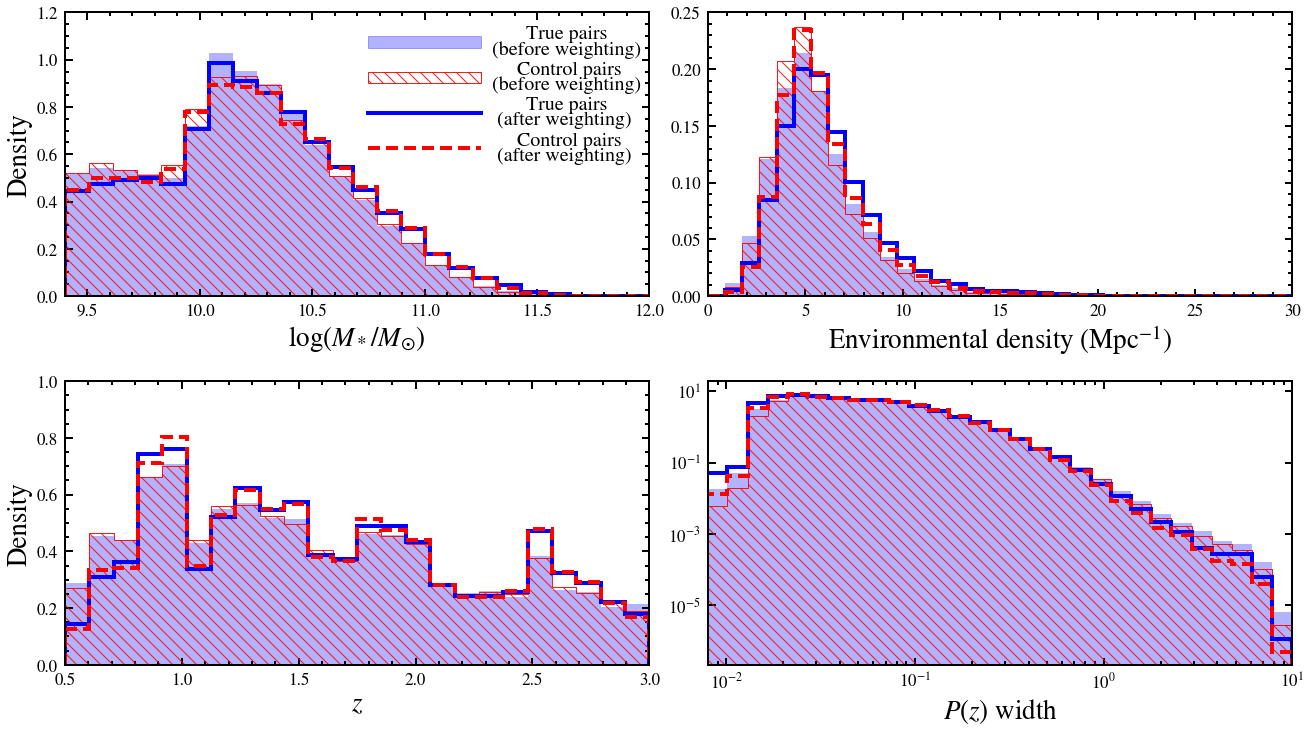

In [14]:
# plot the full weighted and unweighted distributions for the true and control pair samples
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,12), sharey=False)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.1)
zbins = np.linspace(0.5,3,25)
mbins = np.linspace(9.4,12.5,30)  # may actually have the wrong weights here
ebins = np.linspace(0,30,35)
sbins = np.logspace(-2.1,1,30)
wbins = np.logspace(-20,0,200)
pweights = np.concatenate((rdf['pair_prob'],rdf['pair_prob']))
iweights = np.concatenate((cdf['Cp'],cdf['Cp']))

####################
### %%% MASS %%% ###
####################
ax[0,0].hist(pmass, bins=mbins, density=True, color='blue', alpha=0.3, label='pairs w/out weights')
ax[0,0].hist(imass, bins=mbins, density=True, color='red', alpha=0.9, histtype='step',
             hatch=r"\\", label='apples w/out weights')
ax[0,0].hist(pmass, bins=mbins, weights=pweights, density=True, color='blue',
          histtype='step', lw=4, label='pairs')
ax[0,0].hist(imass, bins=mbins, weights=iweights, histtype='step', color='red', 
           density=True, lw=4, linestyle=(0,(3,1.5)), label='controls')
ax[0,0].set_xlim(9.4,12)
# ax[0,0].legend(fontsize=20)
# hand-make legend()
ax[0,0].add_patch(Rectangle((10.75,1.05), 0.5, 0.05, facecolor='blue', edgecolor='blue', alpha=0.3))
ax[0,0].add_patch(Rectangle((10.75,0.9), 0.5, 0.05, facecolor='none', edgecolor='red', alpha=0.9, hatch=r"\\"))
ax[0,0].plot([10.75,11.25],[0.775,0.775], lw=4, color='blue')
ax[0,0].plot([10.75,11.25],[0.775-0.15,0.775-0.15], lw=4, color='red', linestyle=(0,(3,1.5)))
ax[0,0].text(11.45, 1.09, 'True pairs', fontsize=20)
ax[0,0].text(11.3, 1.025, '(before weighting)', fontsize=20)
ax[0,0].text(11.41, 1.09-0.15, 'Control pairs', fontsize=20)
ax[0,0].text(11.3, 1.025-0.15, '(before weighting)', fontsize=20)
ax[0,0].text(11.45, 1.09-0.3, 'True pairs', fontsize=20)
ax[0,0].text(11.32, 1.025-0.3, '(after weighting)', fontsize=20)
ax[0,0].text(11.41, 1.09-0.45, 'Control pairs', fontsize=20)
ax[0,0].text(11.32, 1.025-0.45, '(after weighting)', fontsize=20)
ax[0,0].set_ylabel('Density', fontsize=27)
ax[0,0].set_xlabel('log($M_*/M_☉$)', fontsize=27)
ax[0,0].set_ylim(0,1.2)
ax[0,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

########################
### %%% REDSHIFT %%% ###
########################
ax[1,0].hist(pz, bins=zbins, density=True, color='blue', alpha=0.3)
ax[1,0].hist(iz, bins=zbins, density=True, color='red', alpha=0.9, histtype='step', hatch=r"\\")
ax[1,0].hist(pz, bins=zbins, weights=pweights, density=True, color='blue',
          histtype='step', lw=4)
ax[1,0].hist(iz, bins=zbins, weights=iweights, histtype='step', color='red', 
           density=True, lw=4, linestyle=(0,(3,1.5)))
ax[1,0].set_xlim(0.5, 3)
ax[1,0].set_ylabel('Density', fontsize=27)
ax[1,0].set_xlabel('$z$', fontsize=27)
ax[1,0].set_ylim(0,1)
ax[1,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

#####################################
### %%% ENVIRONMENTAL DENSITY %%% ###
#####################################
ax[0,1].hist(penv, bins=ebins, density=True, color='blue', alpha=0.3)
ax[0,1].hist(ienv, bins=ebins, density=True, color='red', alpha=0.9, histtype='step', hatch=r"\\")
ax[0,1].hist(penv, bins=ebins, weights=pweights, density=True, color='blue',
          histtype='step', lw=4)
ax[0,1].hist(ienv, bins=ebins, weights=iweights, histtype='step', color='red', 
           density=True, lw=4, linestyle=(0,(3,1.5)))
ax[0,1].set_xlim(0, 30)
# ax[0,1].set_ylabel('Density', fontsize=25)
ax[0,1].set_xlabel('Environmental density (Mpc$^{-1}$)', fontsize=27)
ax[0,1].set_ylim(0,0.25)
ax[0,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

##########################
### %%% P(z) WIDTH %%% ###
##########################
ax[1,1].hist(psig, bins=sbins, density=True, color='blue', alpha=0.3)
ax[1,1].hist(isig, bins=sbins, density=True, color='red', alpha=0.9, histtype='step', hatch=r"\\")
ax[1,1].hist(psig, bins=sbins, weights=pweights, density=True, color='blue', histtype='step', lw=4)
ax[1,1].hist(isig, bins=sbins, weights=iweights, density=True, color='red', histtype='step', lw=4, linestyle=(0,(3,1.5)))
ax[1,1].set_xlim(0.008, 10)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('$P(z)$ width', fontsize=27)
ax[1,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1,1].xaxis.set_minor_locator(LogLocator(base=10,subs=np.arange(0.1,1,0.1)))
ax[1,1].yaxis.set_minor_locator(LogLocator(base=10,subs=np.arange(0.1,1,0.1)))
ax[1,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# plt.savefig('/data/c1029594/Figures/Pair_Paper/control_match.png', bbox_inches='tight')

plt.show()

In [15]:
# quantify how similar true and control pair samples are by counting how many are within:
dM = 0.2 # log(stellar mass)
dz = 0.2 # redshift
dE = 4 # environmental density
ds = 0.2 # log(P(z) width)

# combine all matched properties into one df:
rdf2 = rdf[ ['pair_ID', 'prime_ID','partner_ID', 'pair_prob', 'prime_z','partner_z', 'prime_M','partner_M', 'prime_env',
                 'partner_env', 'prime_PDFsig','partner_PDFsig'] ].copy()
cdf2 = cdf[ ['apple_ID', 'ID1','ID2', 'pair_ID', 'z1','z2', 'MASS1','MASS2', 'ENV1','ENV2', 'SIG1','SIG2'] ].copy()
# repeat rdf rows to easily join df with control df
rdf2_rp = pd.DataFrame(np.repeat(rdf2.values, 3, axis=0))
rdf2_rp.columns = rdf2.columns
# np repeat changed data types, change back for log functions below
# mdf (matched df)
mdf = rdf2_rp.join(cdf2, rsuffix='_check')
# find matches that fall within the previously defined property differences
mdf2 = mdf.loc[ (np.abs(mdf['MASS1'] - mdf['prime_M']) < dM) & (np.abs(mdf['MASS2'] - mdf['partner_M']) < dM) &
        (np.abs(mdf['z1'] - mdf['prime_z']) < dz) & (np.abs(mdf['z2'] - mdf['partner_z']) < dz) & 
        (np.abs(mdf['ENV1'] - mdf['prime_env']) < dE) & (np.abs(mdf['ENV2'] - mdf['partner_env']) < dE) &
        (np.abs(np.log10(mdf['SIG1']) - np.log10(mdf['prime_PDFsig'].astype(float))) < ds) & 
        (np.abs(np.log10(mdf['SIG2']) - np.log10(mdf['partner_PDFsig'].astype(float))) < ds) &
        (mdf['pair_prob'] > 0.01) ]
# how many of these are for higher probability pairs 
# (i.e., the ones that really matter in calculating weighted AGN fractions)
mdf3 = mdf.loc[ mdf['pair_prob'] > 0.01 ]
# output the fraction
print('{}% of matches are within these limits'.format(round(len(mdf2)/len(mdf3),2)))


0.93% of matches are within these limits


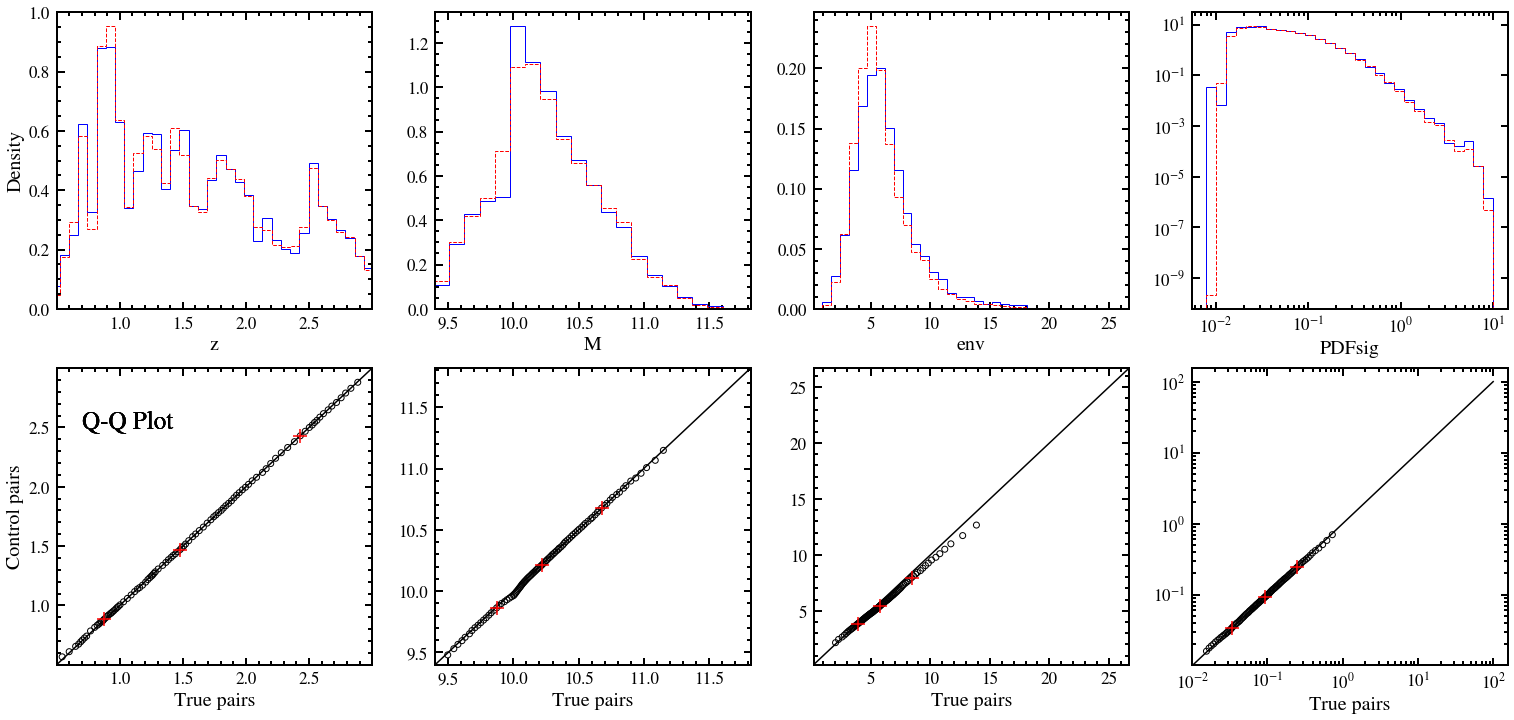

In [16]:
# can also check ditributions of any bin and AGN sample by running bin_analysis() with plot_param=True
# ---> plots weighted distributions and a Q-Q plot with every 0.01 quantiles plotted
# you will need to set up the analysis (i.e., initilaize rdf and cdf) but not actually run the big analysis loop
results = bin_analysis(rdf, cdf, Prp_arr, low, high, 10, 0.5, 3,
                          0, np.log10(4), fields, 'allLX', f_obsc=True, plot_param=True)

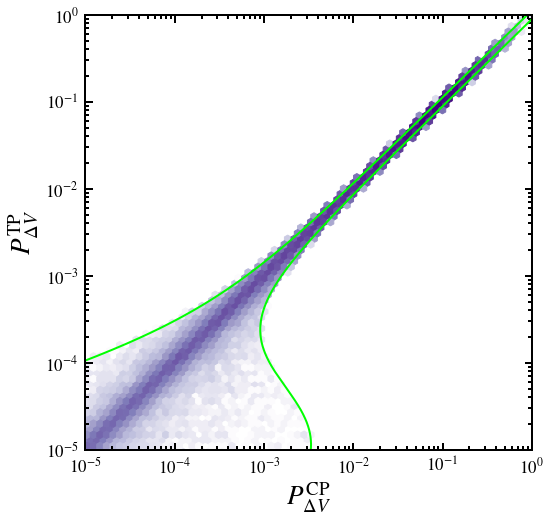

In [17]:
# plot the relative line-of-sight velocities againt each other for true and control pairs
# w.r.t. the matching function (below) and its extrema (2nd and 3rd down)
def PP_diff_func(x):
    '''
    1/x function created using scipy optimize to appropriately contrain differences in true and control pair probabilities.
    Matching function as described in paper.
    INPUTS
    : x - float - a true pair probability
    RETURNS
    : - float - the maximum logarithmic distance between the control and true pair prob (i.e., log(Pp-Cp) < the return)
    '''
    A = 5.24002529e-05
    C = 1.54419221e-04
    return C*(1/(x+A)) + 0.05
def Cp_Pp_low(Pp):
    A = 5.24002529e-05
    C = 1.54419221e-04
    return Pp / 10**((C/(Pp+A))+0.05)
def Cp_Pp_high(Pp):
    A = 5.24002529e-05
    C = 1.54419221e-04
    return Pp * 10**((C/(Pp+A))+0.05)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.hexbin(iweights, np.repeat(pweights,3), gridsize=300, bins='log', xscale='log', yscale='log', cmap='Purples')
x = np.logspace(-6,0,1000)
y1 = Cp_Pp_low(x)
y2 = Cp_Pp_high(x)
ax.plot(y1, x, color='lime', lw=2)
ax.plot(y2, x, color='lime', lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-5,1)
ax.set_ylim(1e-5,1)
ax.set_xlabel('$P^{\\rm CP}_{\Delta V}$', fontsize=27)
ax.set_ylabel('$P^{\\rm TP}_{\Delta V}$', fontsize=27)
ax.tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax.xaxis.set_minor_locator(LogLocator(base=10,subs=np.arange(0.1,1,0.1)))
ax.yaxis.set_minor_locator(LogLocator(base=10,subs=np.arange(0.1,1,0.1)))
ax.tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# plt.savefig('/data/c1029594/Figures/Pair_Paper/PdV_match.png', bbox_inches='tight')

plt.show()

## Plot Results

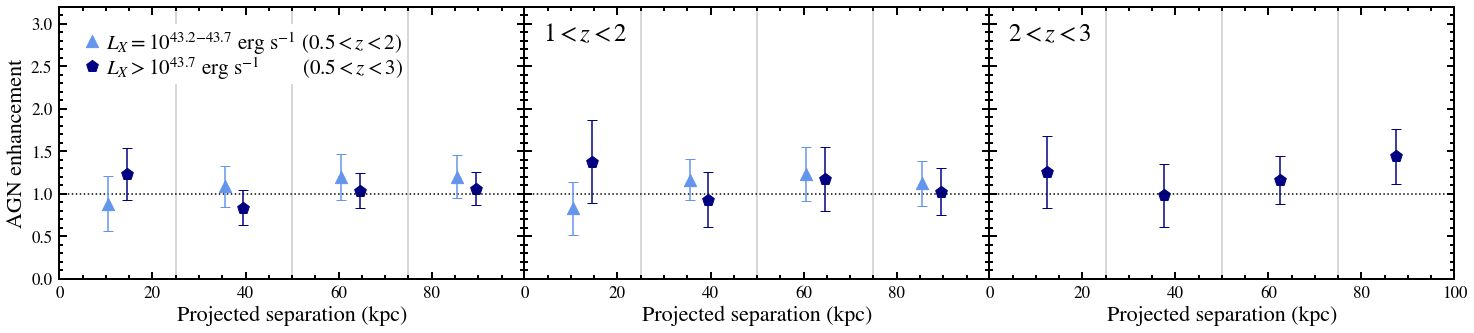

In [18]:
# plot AGN enhancement as a function of projected separation mid and high LX AGN split by redshift
# dictionary keys to be plotted
AGNs = ['midLX', 'midLX_zmid', 'hiLX', 'hiLX_zmid', 'hiLX_zhi']

# add the full sample dictionary entries into the z_major dict:
ps_major_z['midLX_frac'] = ps_major['midLX_frac']
ps_major_z['midLX_se'] = ps_major['midLX_se']
ps_major_z['imidLX_frac'] = ps_major['imidLX_frac']
ps_major_z['imidLX_se'] = ps_major['imidLX_se']
ps_major_z['hiLX_frac'] = ps_major['hiLX_frac']
ps_major_z['hiLX_se'] = ps_major['hiLX_se']
ps_major_z['ihiLX_frac'] = ps_major['ihiLX_frac']
ps_major_z['ihiLX_se'] = ps_major['ihiLX_se']

# low and hi LX data point details
colors = ['cornflowerblue', 'navy']
markers = ['^', 'p']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5), sharey=True, sharex=False)
fig.subplots_adjust(wspace=0)
call, cmid, chi = 0, 0, 0 # counts of each plotted to ensure correct data is plotted in correct panel

# no enhancement (=1) lines
ax[0].plot([-5,105],[1,1], color='black', linestyle=':')
ax[1].plot([-5,105],[1,1], color='black', linestyle=':')
ax[2].plot([-5,105],[1,1], color='black', linestyle=':')

# loop through dictionary and plot
for i, AGN in enumerate(AGNs):
    maj_frac = np.array([ps_major_z[AGN+'_frac'][col] for col in ps_major_z[AGN+'_frac']])
    maj_se = np.array([ps_major_z[AGN+'_se'][col] for col in ps_major_z[AGN+'_se']])
    imaj_frac = np.array([ps_major_z['i'+AGN+'_frac'][col] for col in ps_major_z['i'+AGN+'_frac']])
    imaj_se = np.array([ps_major_z['i'+AGN+'_se'][col] for col in ps_major_z['i'+AGN+'_se']])
    # propogate errors linearly
    maj_enh = maj_frac / imaj_frac
    maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
    # use the key strings to sort data into redshift bins
    read = AGN.split('z')
    if read[-1] == 'mid':
        cmid += 1
        ax[1].scatter(kpc_meds+(2*(2*(cmid-1)-1)), maj_enh, s=150, color=colors[cmid-1], marker=markers[cmid-1])
        ax[1].errorbar(kpc_meds+(2*(2*(cmid-1)-1)), maj_enh, yerr=maj_enh_se, color=colors[cmid-1], capsize=5, linestyle='none')
    elif read[-1] == 'hi':
        chi += 1
        ax[2].scatter(kpc_meds, maj_enh, s=150, color=colors[chi], marker=markers[chi])
        ax[2].errorbar(kpc_meds, maj_enh, yerr=maj_enh_se, color=colors[chi], capsize=5, linestyle='none')
    else:
        call+=1
        ax[0].scatter(kpc_meds+(2*(2*(call-1)-1)), maj_enh, s=150, color=colors[call-1], marker=markers[call-1])
        ax[0].errorbar(kpc_meds+(2*(2*(call-1)-1)), maj_enh, yerr=maj_enh_se, color=colors[call-1], capsize=5, linestyle='none')
        
# add vertical lines to designate bin edges
for kpc in kpc_meds:
    ax[0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=1)
    ax[1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=1)
    ax[2].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=1)

# beautify
ax[0].set_xlim(0,99.9)
ax[0].set_ylim(0,3.2)
ax[0].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[0].set_ylabel('AGN enhancement', fontsize=22)
ax[0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
ax[1].set_xlim(0,99.9)
ax[1].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
ax[2].set_xlim(0,100)
ax[2].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[2].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# add some white rectangles for readability
ax[0].add_patch(Rectangle((4,2.3), 50, 0.7, facecolor='white', edgecolor='white', alpha=1, zorder=2))
# add redshift labels:
ax[1].text(4, 2.8, '$1 < z < 2$', fontsize=25)
ax[2].text(4, 2.8, '$2 < z < 3$', fontsize=25)
# and legend:
ax[0].scatter(7, 2.3+0.2, s=150, color='navy', marker='p', zorder=3)
ax[0].text(10, 2.2+0.2, '$L_X > 10^{43.7}$ erg s$^{-1}$        ($0.5 < z < 3$)', fontsize=21) # '$L_X = 10^{43.2{-}43.7}$'
ax[0].scatter(7, 2.6+0.2, s=150, color='cornflowerblue', marker='^', zorder=3)
ax[0].text(10, 2.5+0.2, '$L_X = 10^{43.2{-}43.7}$ erg s$^{-1}$ ($0.5 < z < 2$)', fontsize=21)

# plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/PAPER_MIDLX-HILX3.png',
#            bbox_inches='tight')
    
plt.show()

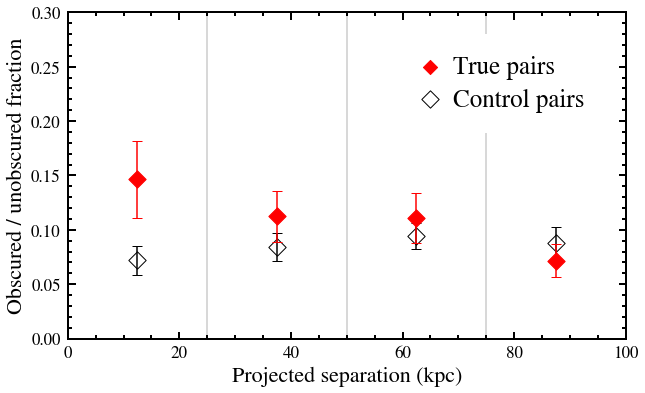

In [19]:
# plot the obscuration fraction (weighted IR-only AGN counts / weighted X-ray AGN counts)
# extract relavent data from results dictionary
maj_frac_obsc = np.array([ps_major['IRallLX_count'][col] for col in ps_major['IRallLX_count']]) # true pairs
maj_frac_LX = np.array([ps_major['allLX_count'][col] for col in ps_major['allLX_count']])
obsc_frac = maj_frac_obsc / maj_frac_LX
imaj_frac_obsc = np.array([ps_major['iIRallLX_count'][col] for col in ps_major['iIRallLX_count']]) # control pairs
imaj_frac_LX = np.array([ps_major['iallLX_count'][col] for col in ps_major['iallLX_count']])
iobsc_frac = imaj_frac_obsc / imaj_frac_LX
# estimate obsc fracs from bootstrap:
pobsc_se = np.zeros(len(ps_major['IRallLX_count']))
iobsc_se = np.zeros(len(ps_major['iIRallLX_count']))
for i, key in enumerate(ps_major['IRallLX_count'].keys()):
    pobsc_se[i] = bootstrap_obsc(ps_obsc_dict['IRallLX_obs'][key], ps_obsc_dict['allLX_obs'][key], ps_obsc_dict['IRallLX_PP'][key])
    iobsc_se[i] = bootstrap_obsc(ps_obsc_dict['iIRallLX_obs'][key], ps_obsc_dict['iallLX_obs'][key], ps_obsc_dict['iIRallLX_PP'][key])

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharey=True, sharex=True)
ax.scatter(kpc_meds, obsc_frac, s=150, marker='D', color='red', zorder=1)
ax.errorbar(kpc_meds, obsc_frac, yerr=pobsc_se, capsize=5, linestyle='none', color='red', zorder=1)
ax.scatter(kpc_meds, iobsc_frac, s=150, marker='D', edgecolor='black', facecolor='white', zorder=0.5)
ax.errorbar(kpc_meds, iobsc_frac, yerr=iobsc_se, capsize=5, linestyle='none', color='black', zorder=0.5)

# add vertical line to designate bin edges
for kpc in kpc_meds:
    ax.plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=1)
    
# build legend
ax.add_patch(Rectangle((69,0.19), 25, 0.09, facecolor='white', edgecolor='white', alpha=1, zorder=2))
ax.scatter(65, 0.25, s=100, marker='D', color='red')
ax.scatter(65, 0.22, s=150, marker='D', edgecolor='black', facecolor='white')
ax.text(69, 0.244, 'True pairs', fontsize=25)
ax.text(69, 0.214, 'Control pairs', fontsize=25)
# and beautify
ax.set_xlim(0,100)
ax.set_ylim(0,0.3)
ax.set_xlabel('Projected separation (kpc)', fontsize=22)
ax.set_ylabel('Obscured / unobscured fraction', fontsize=22)
ax.tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=17, pad=7)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/PAPER_OBSC-FRAC3.png',
#            bbox_inches='tight')

plt.show()

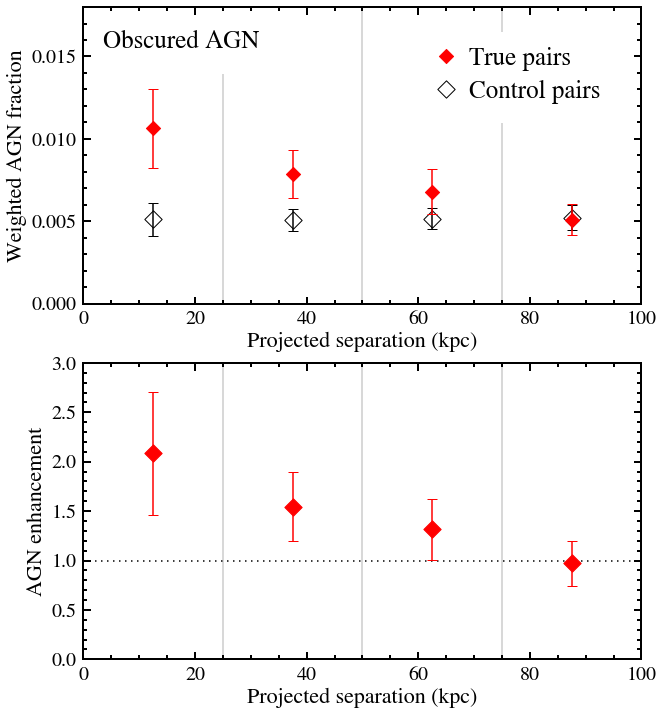

In [20]:
# plot obscured AGN fractions and enhancement
AGN = 'IRallLX'
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,12), sharey=False)
fig.subplots_adjust(wspace=0)
# extract weighted AGN fractions from results dict and plot
maj_frac = np.array([ps_major[AGN+'_frac'][col] for col in ps_major[AGN+'_frac']])
maj_se = np.array([ps_major[AGN+'_se'][col] for col in ps_major[AGN+'_se']])
imaj_frac = np.array([ps_major['i'+AGN+'_frac'][col] for col in ps_major['i'+AGN+'_frac']])
imaj_se = np.array([ps_major['i'+AGN+'_se'][col] for col in ps_major['i'+AGN+'_se']])
ax[0].scatter(kpc_meds, maj_frac, s=100, marker='D', color='red', zorder=1)
ax[0].errorbar(kpc_meds, maj_frac, yerr=maj_se, color='red', capsize=5, linestyle='none', zorder=1)
ax[0].scatter(kpc_meds, imaj_frac, s=150, marker='D', edgecolor='black', facecolor='white', zorder=0.5)
ax[0].errorbar(kpc_meds, imaj_frac, yerr=imaj_se, color='black', capsize=5, linestyle='none', zorder=0.5)
# and beautify
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,0.018)
ax[0].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[0].set_ylabel('Weighted AGN fraction', fontsize=22)
ax[0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# plot AGN enhancements
maj_enh = maj_frac / imaj_frac
# propogate errors linearly
maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
ax[1].scatter(kpc_meds, maj_enh, marker='D', s=150, color='red')
ax[1].errorbar(kpc_meds, maj_enh, yerr=maj_enh_se, color='red', capsize=5, linestyle='none')
ax[1].plot([0,100],[1,1], color='black', linestyle=(0,(1,3)), zorder=0)
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,3)
ax[1].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[1].set_ylabel('AGN enhancement', fontsize=22)
ax[1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)
    
# add vertical lines to designate bin edges
for kpc in kpc_meds:
    ax[0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    ax[1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    
# add label
ax[0].add_patch(Rectangle((2,0.014), 25, 0.09, facecolor='white', edgecolor='white', alpha=1, zorder=0.3))
ax[0].text(3.5, 0.0155, 'Obscured AGN', fontsize=25)
# build legend
ax[0].add_patch(Rectangle((69,0.011), 25, 0.0055, facecolor='white', edgecolor='white', alpha=1, zorder=2))
ax[0].scatter(65, 0.015, s=100, marker='D', color='red')
ax[0].scatter(65, 0.013, s=150, marker='D', edgecolor='black', facecolor='white')
ax[0].text(69, 0.0145, 'True pairs', fontsize=25)
ax[0].text(69, 0.0125, 'Control pairs', fontsize=25)

# plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/PAPER_OBSC-ENH3.png',
#            bbox_inches='tight')
    
plt.show()

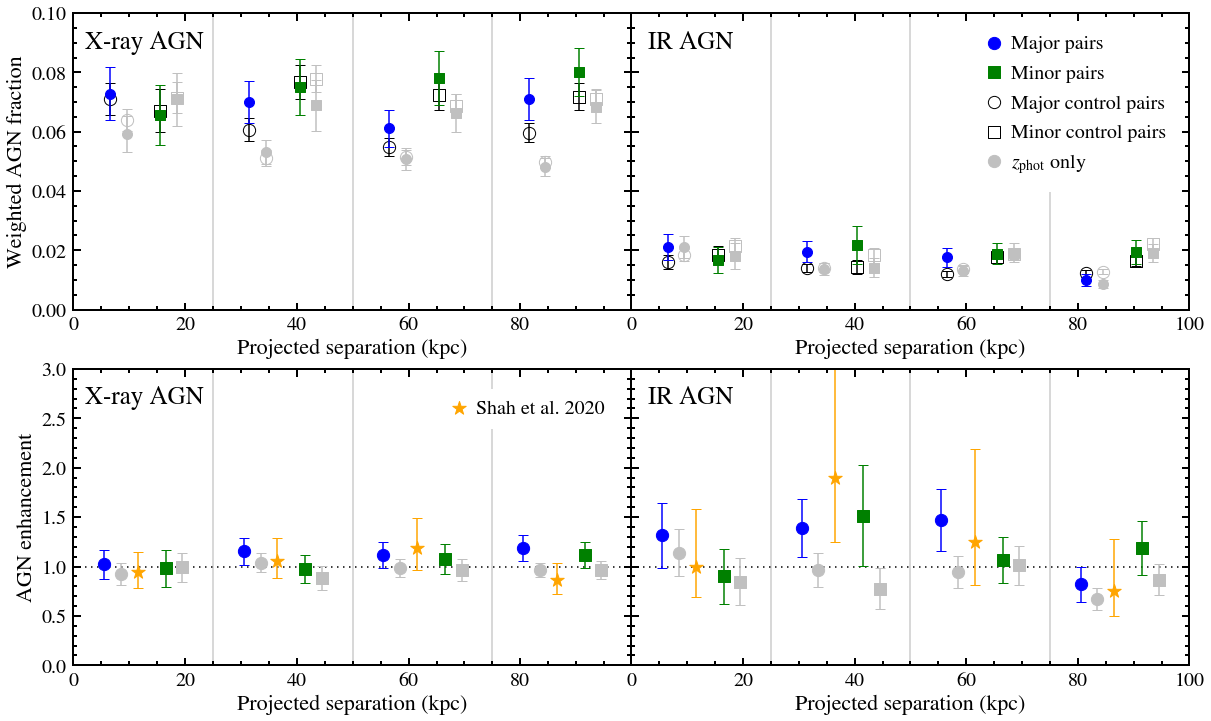

In [21]:
# plot X-ray and IR AGN weighted fractions and enhancements for major and minro galaxy pairs:
# retrieve data from Shah+20
Shah_X = np.array([0.94, 1.06, 1.19, 0.86])
Shah_Xuer = np.array([0.21, 0.23, 0.30, 0.18])
Shah_Xler = np.array([0.16, 0.18, 0.22, 0.14])
Shah_IR = np.array([1.00, 1.90, 1.25, 0.75])
Shah_IRuer = np.array([0.58, 1.25, 0.94, 0.53])
Shah_IRler = np.array([0.31, 0.65, 0.44, 0.25])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12), sharey=False)
fig.subplots_adjust(wspace=0)
#########################
### %%% X-ray AGN %%% ###
#########################
# extract major and minro X-ray AGN results from ps dict as the main results
AGN = 'allLX'
maj_frac = np.array([ps_major[AGN+'_frac'][col] for col in ps_major[AGN+'_frac']])
maj_se = np.array([ps_major[AGN+'_se'][col] for col in ps_major[AGN+'_se']])
imaj_frac = np.array([ps_major['i'+AGN+'_frac'][col] for col in ps_major['i'+AGN+'_frac']])
imaj_se = np.array([ps_major['i'+AGN+'_se'][col] for col in ps_major['i'+AGN+'_se']])
min_frac = np.array([ps_minor[AGN+'_frac'][col] for col in ps_minor[AGN+'_frac']])
min_se = np.array([ps_minor[AGN+'_se'][col] for col in ps_minor[AGN+'_se']])
imin_frac = np.array([ps_minor['i'+AGN+'_frac'][col] for col in ps_minor['i'+AGN+'_frac']])
imin_se = np.array([ps_minor['i'+AGN+'_se'][col] for col in ps_minor['i'+AGN+'_se']])
# also get results from p dict --> zphot only results plotted in grey as confirmation
p_maj_frac = np.array([p_major[AGN+'_frac'][col] for col in p_major[AGN+'_frac']])
p_maj_se = np.array([p_major[AGN+'_se'][col] for col in p_major[AGN+'_se']])
p_imaj_frac = np.array([p_major['i'+AGN+'_frac'][col] for col in p_major['i'+AGN+'_frac']])
p_imaj_se = np.array([p_major['i'+AGN+'_se'][col] for col in p_major['i'+AGN+'_se']])
p_min_frac = np.array([p_minor[AGN+'_frac'][col] for col in p_minor[AGN+'_frac']])
p_min_se = np.array([p_minor[AGN+'_se'][col] for col in p_minor[AGN+'_se']])
p_imin_frac = np.array([p_minor['i'+AGN+'_frac'][col] for col in p_minor['i'+AGN+'_frac']])
p_imin_se = np.array([p_minor['i'+AGN+'_se'][col] for col in p_minor['i'+AGN+'_se']])
# plot
ax[0,0].scatter(kpc_meds-6, maj_frac, s=100, color='blue', zorder=1)
ax[0,0].errorbar(kpc_meds-6, maj_frac, yerr=maj_se, color='blue', capsize=5, linestyle='none', zorder=1)
ax[0,0].scatter(kpc_meds-6, imaj_frac, s=150, edgecolor='black', facecolor='white', zorder=0.5)
ax[0,0].errorbar(kpc_meds-6, imaj_frac, yerr=imaj_se, color='black', capsize=5, linestyle='none', zorder=0.5)
ax[0,0].scatter(kpc_meds+3, min_frac, s=100, color='green', marker='s', zorder=1)
ax[0,0].errorbar(kpc_meds+3, min_frac, yerr=min_se, color='green', capsize=5, linestyle='none', zorder=1)
ax[0,0].scatter(kpc_meds+3, imin_frac, s=150, edgecolor='black', facecolor='white', marker='s', zorder=0.5)
ax[0,0].errorbar(kpc_meds+3, imin_frac, yerr=imin_se, color='black', capsize=5, linestyle='none', zorder=0.5)
ax[0,0].scatter(kpc_meds-3, p_maj_frac, s=100, color='silver', zorder=1)
ax[0,0].errorbar(kpc_meds-3, p_maj_frac, yerr=p_maj_se, color='silver', capsize=5, linestyle='none', zorder=1)
ax[0,0].scatter(kpc_meds-3, p_imaj_frac, s=150, edgecolor='silver', facecolor='white', zorder=0.5)
ax[0,0].errorbar(kpc_meds-3, p_imaj_frac, yerr=p_imaj_se, color='silver', capsize=5, linestyle='none', zorder=0.5)
ax[0,0].scatter(kpc_meds+6, p_min_frac, s=100, color='silver', marker='s', zorder=1)
ax[0,0].errorbar(kpc_meds+6, p_min_frac, yerr=p_min_se, color='silver', capsize=5, linestyle='none', zorder=1)
ax[0,0].scatter(kpc_meds+6, p_imin_frac, s=150, edgecolor='silver', facecolor='white', marker='s', zorder=0.5)
ax[0,0].errorbar(kpc_meds+6, p_imin_frac, yerr=p_imin_se, color='silver', capsize=5, linestyle='none', zorder=0.5)
# beautify
ax[0,0].set_xlim(0,99.9)
ax[0,0].set_ylim(0,0.1)
ax[0,0].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[0,0].set_ylabel('Weighted AGN fraction', fontsize=22)
ax[0,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# calculate AGN enhancements and corresponding errors
# for the primary ps (zspecs and zphots) sample
maj_enh = maj_frac / imaj_frac
min_enh = min_frac / imin_frac
# propogate errors linearly
maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
min_enh_se = min_enh * np.sqrt( (min_se/min_frac)**2 + (imin_se/imin_frac)**2 )
# and for the p (zphot only) validation sample
p_maj_enh = p_maj_frac / p_imaj_frac
p_min_enh = p_min_frac / p_imin_frac
# propogate errors linearly
p_maj_enh_se = p_maj_enh * np.sqrt( (p_maj_se/p_maj_frac)**2 + (p_imaj_se/p_imaj_frac)**2 )
p_min_enh_se = p_min_enh * np.sqrt( (p_min_se/p_min_frac)**2 + (p_imin_se/p_imin_frac)**2 )

ax[1,0].scatter(kpc_meds-7, maj_enh, s=150, color='blue', label='major')
ax[1,0].errorbar(kpc_meds-7, maj_enh, yerr=maj_enh_se, color='blue', capsize=5, linestyle='none')
ax[1,0].scatter(kpc_meds+4, min_enh, s=150, color='green', marker='s', label='minor')
ax[1,0].errorbar(kpc_meds+4, min_enh, yerr=min_enh_se, color='green', capsize=5, linestyle='none')
ax[1,0].scatter(kpc_meds-4, p_maj_enh, s=150, color='silver', label='major')
ax[1,0].errorbar(kpc_meds-4, p_maj_enh, yerr=p_maj_enh_se, color='silver', capsize=5, linestyle='none')
ax[1,0].scatter(kpc_meds+7, p_min_enh, s=150, color='silver', marker='s', label='minor')
ax[1,0].errorbar(kpc_meds+7, p_min_enh, yerr=p_min_enh_se, color='silver', capsize=5, linestyle='none')
ax[1,0].plot([0,100],[1,1], color='black', linestyle=(0,(1,3)), zorder=0)
ax[1,0].set_xlim(0,99.9)
ax[1,0].set_ylim(0,3)
ax[1,0].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[1,0].set_ylabel('AGN enhancement', fontsize=22)
ax[1,0].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

######################
### %%% IR AGN %%% ###
######################
# same as for X-ray AGN but now for the IR results
AGN = 'IR'
maj_frac = np.array([ps_major[AGN+'_frac'][col] for col in ps_major[AGN+'_frac']])
maj_se = np.array([ps_major[AGN+'_se'][col] for col in ps_major[AGN+'_se']])
imaj_frac = np.array([ps_major['i'+AGN+'_frac'][col] for col in ps_major['i'+AGN+'_frac']])
imaj_se = np.array([ps_major['i'+AGN+'_se'][col] for col in ps_major['i'+AGN+'_se']])
min_frac = np.array([ps_minor[AGN+'_frac'][col] for col in ps_minor[AGN+'_frac']])
min_se = np.array([ps_minor[AGN+'_se'][col] for col in ps_minor[AGN+'_se']])
imin_frac = np.array([ps_minor['i'+AGN+'_frac'][col] for col in ps_minor['i'+AGN+'_frac']])
imin_se = np.array([ps_minor['i'+AGN+'_se'][col] for col in ps_minor['i'+AGN+'_se']])
p_maj_frac = np.array([p_major[AGN+'_frac'][col] for col in p_major[AGN+'_frac']])
p_maj_se = np.array([p_major[AGN+'_se'][col] for col in p_major[AGN+'_se']])
p_imaj_frac = np.array([p_major['i'+AGN+'_frac'][col] for col in p_major['i'+AGN+'_frac']])
p_imaj_se = np.array([p_major['i'+AGN+'_se'][col] for col in p_major['i'+AGN+'_se']])
p_min_frac = np.array([p_minor[AGN+'_frac'][col] for col in p_minor[AGN+'_frac']])
p_min_se = np.array([p_minor[AGN+'_se'][col] for col in p_minor[AGN+'_se']])
p_imin_frac = np.array([p_minor['i'+AGN+'_frac'][col] for col in p_minor['i'+AGN+'_frac']])
p_imin_se = np.array([p_minor['i'+AGN+'_se'][col] for col in p_minor['i'+AGN+'_se']])

ax[0,1].scatter(kpc_meds-6, maj_frac, s=100, color='blue', zorder=1)
ax[0,1].errorbar(kpc_meds-6, maj_frac, yerr=maj_se, color='blue', capsize=5, linestyle='none', zorder=1)
ax[0,1].scatter(kpc_meds-6, imaj_frac, s=150, edgecolor='black', facecolor='white', zorder=0.5)
ax[0,1].errorbar(kpc_meds-6, imaj_frac, yerr=imaj_se, color='black', capsize=5, linestyle='none', zorder=0.5)
ax[0,1].scatter(kpc_meds+3, min_frac, s=100, color='green', marker='s', zorder=1)
ax[0,1].errorbar(kpc_meds+3, min_frac, yerr=min_se, color='green', capsize=5, linestyle='none', zorder=1)
ax[0,1].scatter(kpc_meds+3, imin_frac, s=150, edgecolor='black', facecolor='white', marker='s', zorder=0.5)
ax[0,1].errorbar(kpc_meds+3, imin_frac, yerr=imin_se, color='black', capsize=5, linestyle='none', zorder=0.5)
ax[0,1].scatter(kpc_meds-3, p_maj_frac, s=100, color='silver', zorder=1)
ax[0,1].errorbar(kpc_meds-3, p_maj_frac, yerr=p_maj_se, color='silver', capsize=5, linestyle='none', zorder=1)
ax[0,1].scatter(kpc_meds-3, p_imaj_frac, s=150, edgecolor='silver', facecolor='white', zorder=0.5)
ax[0,1].errorbar(kpc_meds-3, p_imaj_frac, yerr=p_imaj_se, color='silver', capsize=5, linestyle='none', zorder=0.5)
ax[0,1].scatter(kpc_meds+6, p_min_frac, s=100, color='silver', marker='s', zorder=1)
ax[0,1].errorbar(kpc_meds+6, p_min_frac, yerr=p_min_se, color='silver', capsize=5, linestyle='none', zorder=1)
ax[0,1].scatter(kpc_meds+6, p_imin_frac, s=150, edgecolor='silver', facecolor='white', marker='s', zorder=0.5)
ax[0,1].errorbar(kpc_meds+6, p_imin_frac, yerr=p_imin_se, color='silver', capsize=5, linestyle='none', zorder=0.5)
ax[0,1].set_xlim(0,100)
ax[0,1].set_ylim(0,0.1)
ax[0,1].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[0,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
ax[0,1].yaxis.set_ticklabels([])
ax[0,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

# AGN enhancements
maj_enh = maj_frac / imaj_frac
min_enh = min_frac / imin_frac
# propogate errors linearly
maj_enh_se = maj_enh * np.sqrt( (maj_se/maj_frac)**2 + (imaj_se/imaj_frac)**2 )
min_enh_se = min_enh * np.sqrt( (min_se/min_frac)**2 + (imin_se/imin_frac)**2 )
p_maj_enh = p_maj_frac / p_imaj_frac
p_min_enh = p_min_frac / p_imin_frac
# propogate errors linearly
p_maj_enh_se = p_maj_enh * np.sqrt( (p_maj_se/p_maj_frac)**2 + (p_imaj_se/p_imaj_frac)**2 )
p_min_enh_se = p_min_enh * np.sqrt( (p_min_se/p_min_frac)**2 + (p_imin_se/p_imin_frac)**2 )

ax[1,1].scatter(kpc_meds-7, maj_enh, s=150, color='blue', label='major')
ax[1,1].errorbar(kpc_meds-7, maj_enh, yerr=maj_enh_se, color='blue', capsize=5, linestyle='none')
ax[1,1].scatter(kpc_meds+4, min_enh, s=150, color='green', marker='s', label='minor')
ax[1,1].errorbar(kpc_meds+4, min_enh, yerr=min_enh_se, color='green', capsize=5, linestyle='none')
ax[1,1].scatter(kpc_meds-4, p_maj_enh, s=150, color='silver', label='major')
ax[1,1].errorbar(kpc_meds-4, p_maj_enh, yerr=p_maj_enh_se, color='silver', capsize=5, linestyle='none')
ax[1,1].scatter(kpc_meds+7, p_min_enh, s=150, color='silver', marker='s', label='minor')
ax[1,1].errorbar(kpc_meds+7, p_min_enh, yerr=p_min_enh_se, color='silver', capsize=5, linestyle='none')
ax[1,1].plot([0,100],[1,1], color='black', linestyle=(0,(1,3)), zorder=0)
ax[1,1].set_xlim(0,100)
ax[1,1].set_ylim(0,3)
ax[1,1].set_xlabel('Projected separation (kpc)', fontsize=22)
ax[1,1].tick_params(direction='in', which='major', width=2, length=7.5, top=True, right=True, labelsize=20, pad=7)
ax[1,1].yaxis.set_ticklabels([])
ax[1,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].tick_params(direction='in', which='minor', width=2, length=4, top=True, right=True)

###########
### %%% ###
###########

# add Shah points to enhancement plots:
ax[1,0].scatter(kpc_meds-1, Shah_X, s=200, marker='*', color='orange')
ax[1,0].errorbar(kpc_meds-1, Shah_X, yerr=(Shah_Xler, Shah_Xuer), capsize=5, color='orange', linestyle='none')
ax[1,1].scatter(kpc_meds-1, Shah_IR, s=200, marker='*', color='orange')
ax[1,1].errorbar(kpc_meds-1, Shah_IR, yerr=(Shah_IRler, Shah_IRuer), capsize=5, color='orange', linestyle='none')

# create legend
ax[0,1].scatter(65, 0.09, s=150, color='blue', marker='o', zorder=0.4)
ax[0,1].scatter(65, 0.08, s=150, color='green', marker='s', zorder=0.4)
ax[0,1].scatter(65, 0.07, s=150, edgecolor='black', facecolor='white', marker='o', zorder=0.4)
ax[0,1].scatter(65, 0.06, s=150, edgecolor='black', facecolor='white', marker='s', zorder=0.4)
ax[0,1].scatter(65, 0.05, s=150, color='silver', marker='o', zorder=0.4)
ax[1,0].scatter(69, 2.6, s=200, color='orange', marker='*', zorder=0.4)
ax[0,1].add_patch(Rectangle((52,0.04), 25, 0.09, facecolor='white', edgecolor='white', alpha=1, zorder=0.3))
ax[1,0].add_patch(Rectangle((52,2.4), 25, 0.4, facecolor='white', edgecolor='white', alpha=1, zorder=0.3))
ax[1,0].text(72, 2.55, 'Shah et al. 2020', fontsize=20)
ax[0,1].text(68, 0.088, 'Major pairs', fontsize=20)
ax[0,1].text(68, 0.078, 'Minor pairs', fontsize=20)
ax[0,1].text(68, 0.068, 'Major control pairs', fontsize=20)
ax[0,1].text(68, 0.058, 'Minor control pairs', fontsize=20)
ax[0,1].text(68, 0.048, '$z_{\\rm phot}$ only', fontsize=20)

# label panels by AGN type
ax[0,0].text(2, 0.088, 'X-ray AGN', fontsize=25)
ax[0,1].text(3, 0.088, 'IR AGN', fontsize=25)
ax[1,0].text(2, 2.65, 'X-ray AGN', fontsize=25)
ax[1,1].text(3, 2.65, 'IR AGN', fontsize=25)

# add vertical lines to desigate bin edges
for kpc in kpc_meds:
    ax[0,0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    ax[1,0].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    ax[0,1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    ax[1,1].plot([kpc_centers,kpc_centers], [0,100], color='black', alpha=0.05, zorder=0.2)
    
# plt.savefig('/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/results/PAPER_XAGN-IRAGN3.png',
#            bbox_inches='tight')
    
plt.show()